In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import gridspec
from scipy import stats

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
features_sig=pd.read_hdf("/data1/bpnachman/anomaly/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")
features_bg=pd.read_hdf("/data1/bpnachman/anomaly/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
features_bg2=pd.read_hdf("/data1/bpnachman/anomaly/events_anomalydetection_DelphesHerwig_qcd_features.h5")

In [4]:
def load_data(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)
    dataset["mjDelta"] = dataset["mjTwo"] - dataset["mjOne"]
    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    dataset["mjTwo"] = dataset["mjTwo"]/1000.
    dataset["mjOne"] = dataset["mjOne"]/1000.
    dataset["mjDelta"] = dataset["mjDelta"]/1000.
    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta","tau21jOne","tau21jTwo"]]
    return dataset.to_numpy()

In [63]:
dataset_bg=load_data(features_bg)
dataset_bg=np.hstack((dataset_bg,np.zeros((len(dataset_bg),1))))

dataset_bg2=load_data(features_bg2)
dataset_bg2=np.hstack((dataset_bg2,np.zeros((len(dataset_bg2),1))))

dataset_sig=load_data(features_sig)
dataset_sig=np.hstack((dataset_sig,np.ones((len(dataset_sig),1))))

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value

In [6]:
def make_plot(pyth,sig,mybins=np.linspace(1000,10000,100),mylabel="$m_{JJ}$ [GeV]",myname="mjj",myscale=5,dolog=True,donormalize=False,myloc="upper left"):

    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    npmjj,bmjj,_=plt.hist(pyth,bins=mybins,alpha=0.5,label="Background",density=donormalize)
    nhmjj,_,_=plt.hist(sig,bins=mybins,histtype='step',color='black',label="Signal",density=donormalize)
    plt.ylabel("Events",fontsize=20)
    if (donormalize):
        plt.ylabel("Normalized to unity",fontsize=20)
        pass
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    if (dolog):
        plt.yscale('log')
        plt.ylim(1,max(npmjj)*myscale)
        pass
    else:
        plt.ylim(0,max(npmjj)*myscale)
    plt.legend(frameon=False,fontsize=20,loc=myloc)
    plt.xlabel(r""+mylabel,fontsize=20)

    plt.tight_layout()
    plt.savefig("plots/"+myname+".pdf")
    pass

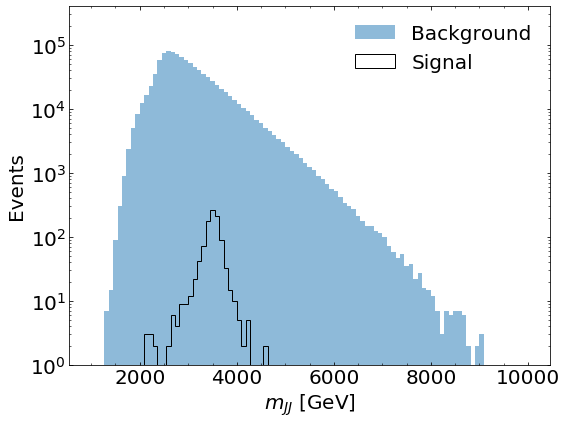

In [7]:
make_plot(1000*dataset_bg[:,0],1000*dataset_sig[:,0][0:1000],np.linspace(1000,10000,100),"$m_{JJ}$ [GeV]","mjj",myloc="upper right")

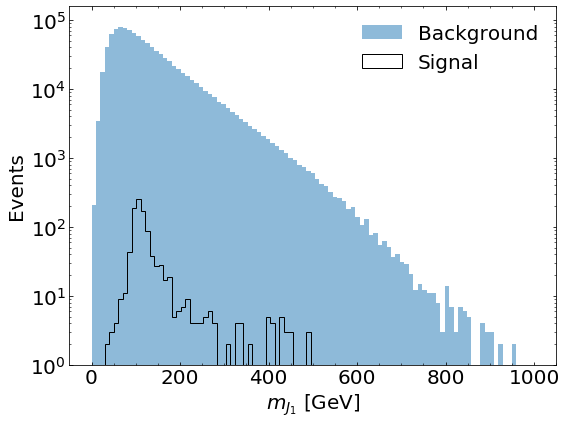

In [8]:
make_plot(1000*dataset_bg[:,1],1000*dataset_sig[:,1][0:1000],np.linspace(0,1000,100),"$m_{J_{1}}$ [GeV]","minmj",2,True,False,"upper right")

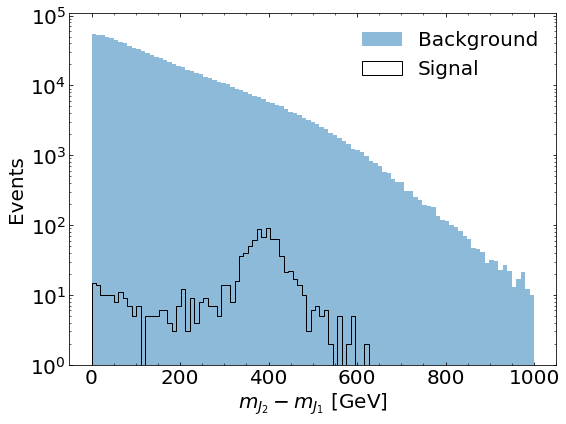

In [9]:
make_plot(1000*dataset_bg[:,2],1000*dataset_sig[:,2][0:1000],np.linspace(0,1000,100),"$m_{J_{2}}-m_{J_{1}}$ [GeV]","maxmj",2,True,False,"upper right")

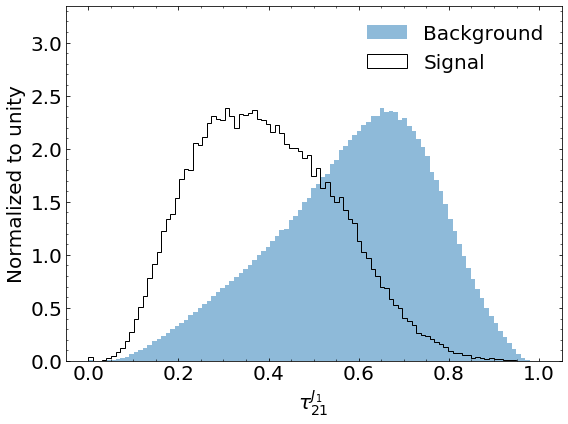

In [10]:
make_plot(dataset_bg[:,3],dataset_sig[:,3],np.linspace(0,1,100),"$\\tau_{21}^{J_{1}}$","mintau21",1.4,False,True,"upper right")

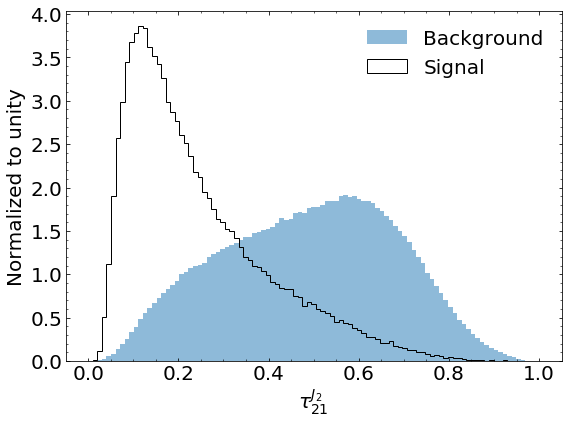

In [11]:
make_plot(dataset_bg[:,4],dataset_sig[:,4],np.linspace(0,1,100),"$\\tau_{21}^{J_{2}}$","maxtau21",2.1,False,True,"upper right")

In [167]:
#Make the dataset

dataset_sig_shifted = dataset_sig.copy()
dataset_bg_shifted = dataset_bg.copy()
dataset_bg2_shifted = dataset_bg2.copy()

shift = 0.1

dataset_sig_shifted[:,1] = dataset_sig_shifted[:,1] + shift*dataset_sig_shifted[:,0]
dataset_sig_shifted[:,2] = dataset_sig_shifted[:,2] + shift*dataset_sig_shifted[:,0]

dataset_bg_shifted[:,1] = dataset_bg_shifted[:,1] + shift*dataset_bg_shifted[:,0]
dataset_bg_shifted[:,2] = dataset_bg_shifted[:,2] + shift*dataset_bg_shifted[:,0]

dataset_bg2_shifted[:,1] = dataset_bg2_shifted[:,1] + shift*dataset_bg2_shifted[:,0]
dataset_bg2_shifted[:,2] = dataset_bg2_shifted[:,2] + shift*dataset_bg2_shifted[:,0]

In [590]:
#CWoLa
model_cwola = Sequential()
model_cwola.add(Dense(64, input_dim=4, activation='relu')) 
model_cwola.add(Dense(64, activation='relu'))
model_cwola.add(Dense(64, activation='relu'))
model_cwola.add(Dense(1, activation='sigmoid'))
model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_sacwola = Sequential()
model_sacwola.add(Dense(64, input_dim=4, activation='relu')) 
model_sacwola.add(Dense(64, activation='relu'))
model_sacwola.add(Dense(64, activation='relu'))
model_sacwola.add(Dense(1, activation='sigmoid'))
model_sacwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

SR_low = 3.3
SR_high = 3.7

X_sig_inject = dataset_sig_shifted[0:500]
X_sig_inject2 = dataset_sig_shifted[500:1000]
X_sig_test = dataset_sig_shifted[500:-1]
X_bg_SR = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,1:5]
X_bg_SR_train = X_bg_SR[0:int(0.5*len(X_bg_SR))]
X_bg_SR_test = X_bg_SR[int(0.5*len(X_bg_SR)):-1]
X_bg2_SR = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,1:5]
X_bg2_SR_train = X_bg2_SR[0:int(0.5*len(X_bg2_SR))]
X_bg2_SR_test = X_bg2_SR[int(0.5*len(X_bg2_SR)):-1]
X_sig_SR_train = X_sig_inject[(X_sig_inject[:,0] > SR_low)*(X_sig_inject[:,0] < SR_high)][:,1:5]
X_sig_SR_test = X_sig_test[(X_sig_test[:,0] > SR_low)*(X_sig_test[:,0] < SR_high)][:,1:5]

SB_low = 3.1
SB_high = 3.9

X_background_inject = dataset_bg_shifted[0:int(0.5*len(dataset_bg))]
X_sig_SB_low = X_sig_inject[(X_sig_inject[:,0] > SB_low)*(X_sig_inject[:,0] < SR_low)][:,1:5]
X_bg_SB_low = X_background_inject[(X_background_inject[:,0] > SB_low)*(X_background_inject[:,0] < SR_low)][:,1:5]
X_sig_SB_high = X_sig_inject[(X_sig_inject[:,0] > SR_high)*(X_sig_inject[:,0] < SB_high)][:,1:5]
X_bg_SB_high = X_background_inject[(X_background_inject[:,0] > SR_high)*(X_background_inject[:,0] < SB_high)][:,1:5]

X_background_fortest = dataset_bg_shifted[int(0.5*len(dataset_bg)):-1]
X_sig_SB_low_test = X_sig_inject2[(X_sig_inject2[:,0] > SB_low)*(X_sig_inject2[:,0] < SR_low)][:,1:5]
X_bg_SB_low_test = X_background_fortest[(X_background_fortest[:,0] > SB_low)*(X_background_fortest[:,0] < SR_low)][:,1:5]
X_sig_SB_high_test = X_sig_inject2[(X_sig_inject2[:,0] > SR_high)*(X_sig_inject2[:,0] < SB_high)][:,1:5]
X_bg_SB_high_test = X_background_fortest[(X_background_fortest[:,0] > SR_high)*(X_background_fortest[:,0] < SB_high)][:,1:5]

X_test = np.concatenate([X_sig_SR_test,X_bg_SR_test])
Y_test = np.concatenate([np.ones(len(X_sig_SR_test)),np.zeros(len(X_bg_SR_test))])

mylambda = 0.5

X_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low,X_bg_SB_low,X_sig_SB_high,X_bg_SB_high,
                         X_bg2_SR_train,X_bg2_SB_low,X_bg2_SB_high])
Y_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low)),np.zeros(len(X_bg_SB_low)),np.zeros(len(X_sig_SB_high)),np.zeros(len(X_bg_SB_high)),
                         np.ones(len(X_bg2_SR_train)),np.zeros(len(X_bg2_SB_low)),np.zeros(len(X_bg2_SB_high))])
w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low)+len(X_bg_SB_low))
w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high)+len(X_bg_SB_high))
w2_low = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_low)+len(X_bg2_SB_low))
w2_high = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_high)+len(X_bg2_SB_high))
W_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low)),w_low*np.ones(len(X_bg_SB_low)),w_high*np.ones(len(X_sig_SB_high)),w_high*np.ones(len(X_bg_SB_high)),
                         -mylambda*np.ones(len(X_bg2_SR_train)),-mylambda*w_low*np.ones(len(X_bg2_SB_low)),-mylambda*w_high*np.ones(len(X_bg2_SB_high))])

X_testSB = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low_test,X_bg_SB_low_test,X_sig_SB_high_test,X_bg_SB_high_test])
Y_testSB = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low_test)),np.zeros(len(X_bg_SB_low_test)),np.zeros(len(X_sig_SB_high_test)),np.zeros(len(X_bg_SB_high_test))])
w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low_test)+len(X_bg_SB_low_test))
w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high_test)+len(X_bg_SB_high_test))
W_testSB = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low_test)),w_low*np.ones(len(X_bg_SB_low_test)),w_high*np.ones(len(X_sig_SB_high_test)),w_high*np.ones(len(X_bg_SB_high_test))])

model_sacwola.fit(X_train,Y_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test),sample_weight=W_train)

preds_hold = model_sacwola.predict(X_test,batch_size=10000)[:,0]
preds_holdSB = model_sacwola.predict(X_testSB,batch_size=10000)[:,0]
fpr_sacwola, tpr_sacwola, _ = roc_curve(Y_test, preds_hold)
fprSB_sacwola, tprSB_sacwola, _ = roc_curve(Y_testSB, preds_holdSB, sample_weight=W_testSB)

###

mylambda = 0.

X_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low,X_bg_SB_low,X_sig_SB_high,X_bg_SB_high,
                         X_bg2_SR_train,X_bg2_SB_low,X_bg2_SB_high])
Y_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low)),np.zeros(len(X_bg_SB_low)),np.zeros(len(X_sig_SB_high)),np.zeros(len(X_bg_SB_high)),
                         np.ones(len(X_bg2_SR_train)),np.zeros(len(X_bg2_SB_low)),np.zeros(len(X_bg2_SB_high))])
w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low)+len(X_bg_SB_low))
w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high)+len(X_bg_SB_high))
w2_low = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_low)+len(X_bg2_SB_low))
w2_high = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_high)+len(X_bg2_SB_high))
W_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low)),w_low*np.ones(len(X_bg_SB_low)),w_high*np.ones(len(X_sig_SB_high)),w_high*np.ones(len(X_bg_SB_high)),
                         -mylambda*np.ones(len(X_bg2_SR_train)),-mylambda*w_low*np.ones(len(X_bg2_SB_low)),-mylambda*w_high*np.ones(len(X_bg2_SB_high))])

X_testSB = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low_test,X_bg_SB_low_test,X_sig_SB_high_test,X_bg_SB_high_test])
Y_testSB = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low_test)),np.zeros(len(X_bg_SB_low_test)),np.zeros(len(X_sig_SB_high_test)),np.zeros(len(X_bg_SB_high_test))])
w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low_test)+len(X_bg_SB_low_test))
w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high_test)+len(X_bg_SB_high_test))
W_testSB = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low_test)),w_low*np.ones(len(X_bg_SB_low_test)),w_high*np.ones(len(X_sig_SB_high_test)),w_high*np.ones(len(X_bg_SB_high_test))])

model_cwola.fit(X_train,Y_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test),sample_weight=W_train)

preds_hold = model_cwola.predict(X_test,batch_size=10000)[:,0]
preds_holdSB = model_cwola.predict(X_testSB,batch_size=10000)[:,0]
fpr_cwola, tpr_cwola, _ = roc_curve(Y_test, preds_hold)
fprSB_cwola, tprSB_cwola, _ = roc_curve(Y_testSB, preds_holdSB, sample_weight=W_testSB)

Train on 252674 samples, validate on 135581 samples
Epoch 1/10
252674/252674 [==============================] - 22s 88us/step - loss: 0.1665 - acc: 0.4988 - val_loss: 0.6882 - val_acc: 0.5641
Epoch 2/10
252674/252674 [==============================] - 12s 47us/step - loss: 0.1664 - acc: 0.4974 - val_loss: 0.6887 - val_acc: 0.5525
Epoch 3/10
252674/252674 [==============================] - 12s 47us/step - loss: 0.1664 - acc: 0.4894 - val_loss: 0.6922 - val_acc: 0.5529
Epoch 4/10
252674/252674 [==============================] - 12s 47us/step - loss: 0.1664 - acc: 0.4867 - val_loss: 0.6394 - val_acc: 0.6861
Epoch 5/10
252674/252674 [==============================] - 12s 47us/step - loss: 0.1664 - acc: 0.4919 - val_loss: 0.6411 - val_acc: 0.8484
Epoch 6/10
252674/252674 [==============================] - 12s 47us/step - loss: 0.1663 - acc: 0.4920 - val_loss: 0.6503 - val_acc: 0.5831
Epoch 7/10
252674/252674 [==============================] - 12s 47us/step - loss: 0.1662 - acc: 0.4996 - val

In [169]:
#Optimal CWoLa

model_cwola_optimal = Sequential()
model_cwola_optimal.add(Dense(64, input_dim=4, activation='relu')) 
model_cwola_optimal.add(Dense(64, activation='relu'))
model_cwola_optimal.add(Dense(64, activation='relu'))
model_cwola_optimal.add(Dense(1, activation='sigmoid'))
model_cwola_optimal.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_bg_SR_test])
Y_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg_SR_test))])

model_cwola_optimal.fit(X_train,Y_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test))

Train on 121742 samples, validate on 135581 samples
Epoch 1/10
121742/121742 [==============================] - 7s 59us/step - loss: 0.6933 - acc: 0.5014 - val_loss: 0.6836 - val_acc: 0.7969
Epoch 2/10
121742/121742 [==============================] - 5s 44us/step - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6848 - val_acc: 0.8228
Epoch 3/10
121742/121742 [==============================] - 5s 45us/step - loss: 0.6932 - acc: 0.5007 - val_loss: 0.6835 - val_acc: 0.7993
Epoch 4/10
121742/121742 [==============================] - 5s 43us/step - loss: 0.6931 - acc: 0.5038 - val_loss: 0.6890 - val_acc: 0.5525
Epoch 5/10
121742/121742 [==============================] - 5s 44us/step - loss: 0.6931 - acc: 0.5026 - val_loss: 0.6719 - val_acc: 0.5525
Epoch 6/10
121742/121742 [==============================] - 5s 44us/step - loss: 0.6931 - acc: 0.5009 - val_loss: 0.6817 - val_acc: 0.8427
Epoch 7/10
121742/121742 [==============================] - 5s 44us/step - loss: 0.6931 - acc: 0.5029 - val_loss: 

In [170]:
preds_hold = model_cwola_optimal.predict(X_test,batch_size=10000)[:,0]
fpr_ocwola, tpr_ocwola, _ = roc_curve(Y_test, preds_hold)

In [171]:
#SALAD

model_reweighter = Sequential()
model_reweighter.add(Dense(64, input_dim=5, activation='relu')) 
model_reweighter.add(Dense(64, activation='relu'))
model_reweighter.add(Dense(64, activation='relu'))
model_reweighter.add(Dense(1, activation='sigmoid'))
model_reweighter.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

SB_low_long = 3.1-0.3
SB_high_long = 3.9+0.3

X_sig_SB_low_long = X_sig_inject[(X_sig_inject[:,0] > SB_low_long)*(X_sig_inject[:,0] < SR_low)][:,0:5]
X_sig_SB_high_long = X_sig_inject[(X_sig_inject[:,0] > SR_high)*(X_sig_inject[:,0] < SB_high_long)][:,0:5]
X_bg_SB_low_long = X_background_inject[(X_background_inject[:,0] > SB_low_long)*(X_background_inject[:,0] < SR_low)][:,0:5]
X_bg_SB_high_long = X_background_inject[(X_background_inject[:,0] > SR_high)*(X_background_inject[:,0] < SB_high_long)][:,0:5]
X_bg2_SB_low_long = X_background2_inject[(X_background2_inject[:,0] > SB_low_long)*(X_background2_inject[:,0] < SR_low)][:,0:5]
X_bg2_SB_high_long = X_background2_inject[(X_background2_inject[:,0] > SR_high)*(X_background2_inject[:,0] < SB_high_long)][:,0:5]

Xs_train_rw = np.concatenate([X_bg_SB_low_long,X_bg_SB_high_long,X_bg2_SB_low_long,X_bg2_SB_high_long])
Ys_train_rw = np.concatenate([np.ones(len(X_bg_SB_low_long)),np.ones(len(X_bg_SB_high_long)),np.zeros(len(X_bg2_SB_low_long)),np.zeros(len(X_bg2_SB_high_long))])

model_reweighter.fit(Xs_train_rw,Ys_train_rw, epochs=30, batch_size=200)

X_bg_SR_forw = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,0:5]
X_bg_SR_train_forw = X_bg_SR_forw[0:int(0.5*len(X_bg_SR))]
X_bg2_SR_forw = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,0:5]
X_bg2_SR_train_forw = X_bg2_SR_forw[0:int(0.5*len(X_bg2_SR))]
X_sig_SR_train_forw = X_sig_inject[(X_sig_inject[:,0] > SR_low)*(X_sig_inject[:,0] < SR_high)][:,0:5]

preds = model_reweighter.predict(np.concatenate([X_sig_SR_train_forw,X_bg_SR_train_forw,X_bg2_SR_train_forw]),batch_size=10000)
weights_salad = preds / (1.-preds)
weights_salad = weights_salad[:,0]
isdata = np.concatenate([np.ones(len(X_sig_SR_train_forw)),np.ones(len(X_bg_SR_train_forw)),np.zeros(len(X_bg2_SR_train_forw))])
weights_salad[isdata==1]=1.

model_salad = Sequential()
model_salad.add(Dense(64, input_dim=4, activation='relu')) 
model_salad.add(Dense(64, activation='relu'))
model_salad.add(Dense(64, activation='relu'))
model_salad.add(Dense(1, activation='sigmoid'))
model_salad.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_datavsim = Sequential()
model_datavsim.add(Dense(64, input_dim=4, activation='relu')) 
model_datavsim.add(Dense(64, activation='relu'))
model_datavsim.add(Dense(64, activation='relu'))
model_datavsim.add(Dense(1, activation='sigmoid'))
model_datavsim.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Xs_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_bg2_SR_train])
Ys_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg2_SR_train))])

model_salad.fit(Xs_train,Ys_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test),sample_weight=weights_salad)
model_datavsim.fit(Xs_train,Ys_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test))

Epoch 1/30
361941/361941 [==============================] - 13s 36us/step - loss: 0.6854 - acc: 0.5498
Epoch 2/30
361941/361941 [==============================] - 11s 31us/step - loss: 0.6834 - acc: 0.5564
Epoch 3/30
361941/361941 [==============================] - 11s 32us/step - loss: 0.6827 - acc: 0.5582
Epoch 4/30
361941/361941 [==============================] - 12s 32us/step - loss: 0.6821 - acc: 0.5602
Epoch 5/30
361941/361941 [==============================] - 11s 31us/step - loss: 0.6817 - acc: 0.5606
Epoch 6/30
361941/361941 [==============================] - 11s 31us/step - loss: 0.6815 - acc: 0.5602
Epoch 7/30
361941/361941 [==============================] - 11s 31us/step - loss: 0.6814 - acc: 0.5613
Epoch 8/30
361941/361941 [==============================] - 12s 32us/step - loss: 0.6812 - acc: 0.5613
Epoch 9/30
361941/361941 [==============================] - 12s 32us/step - loss: 0.6811 - acc: 0.5612
Epoch 10/30
361941/361941 [==============================] - 12s 32us/ste

In [172]:
ww = model_reweighter.predict(X_bg2_SR_train_forw,batch_size=10000)
ww = ww / (1.-ww)

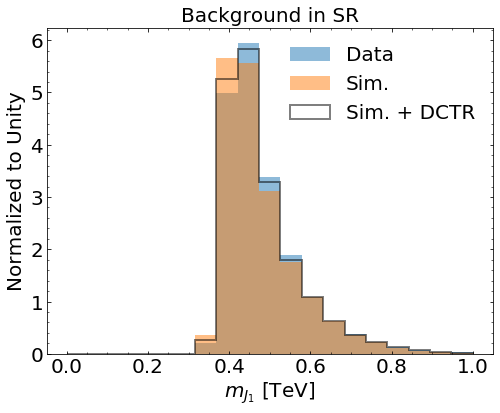

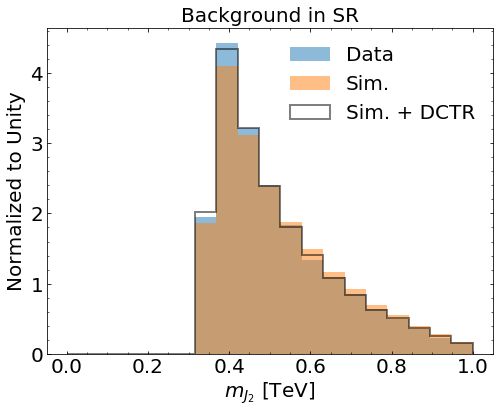

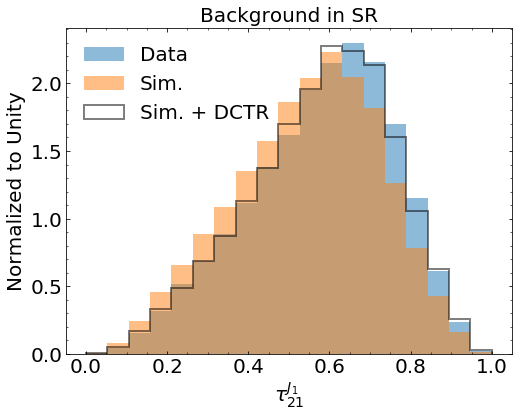

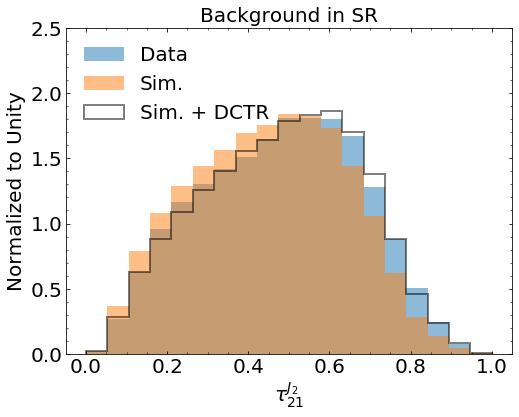

In [247]:
mynames=["$m_{J_1}$ [TeV]","$m_{J_2}$ [TeV]",r"$\tau_{21}^{J_1}$",r"$\tau_{21}^{J_2}$"]
for i in range(1,5):
    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.xlabel(mynames[i-1],fontsize=20)
    plt.ylabel("Normalized to Unity",fontsize=20)
    plt.title("Background in SR",fontsize=20)
    
    if (i==4): plt.ylim([0,2.5])

    plt.hist(X_bg_SR_train_forw[:,i],bins=np.linspace(0,1,20),alpha=0.5,density=True,label="Data")
    plt.hist(X_bg2_SR_train_forw[:,i],bins=np.linspace(0,1,20),alpha=0.5,density=True,label="Sim.")
    plt.hist(X_bg2_SR_train_forw[:,i],bins=np.linspace(0,1,20),alpha=0.5,weights=ww,density=True,histtype="step",color="black",label="Sim. + DCTR",linewidth=2)
    plt.legend(frameon=False,fontsize=20)
    plt.savefig('SA-CWoLa/features'+str(i)+'.pdf',bbox_inches='tight')

In [174]:
preds_hold = model_salad.predict(X_test,batch_size=10000)[:,0]
fpr_salad, tpr_salad, _ = roc_curve(Y_test, preds_hold)

In [178]:
preds_hold = model_datavsim.predict(X_test,batch_size=10000)[:,0]
fpr_datavsim, tpr_datavsim, _ = roc_curve(Y_test, preds_hold)

In [175]:
#Let's train a fully supervised classifier
model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu')) 
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Xfully_train = np.concatenate([X_sig_SR_train,X_bg_SR_train])
#Yfully_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train))])

model.fit(X_test,Y_test, epochs=10, batch_size=200,validation_data=(X_test,Y_test))
preds = model.predict(X_test,batch_size=10000)
fpr_fully, tpr_fully, _ = roc_curve(Y_test, preds)

Train on 135581 samples, validate on 135581 samples
Epoch 1/10
135581/135581 [==============================] - 8s 63us/step - loss: 0.3472 - acc: 0.8616 - val_loss: 0.3112 - val_acc: 0.8747
Epoch 2/10
135581/135581 [==============================] - 6s 47us/step - loss: 0.3108 - acc: 0.8749 - val_loss: 0.3045 - val_acc: 0.8778
Epoch 3/10
135581/135581 [==============================] - 6s 47us/step - loss: 0.2980 - acc: 0.8800 - val_loss: 0.2903 - val_acc: 0.8837
Epoch 4/10
135581/135581 [==============================] - 6s 47us/step - loss: 0.2727 - acc: 0.8915 - val_loss: 0.2764 - val_acc: 0.8868
Epoch 5/10
135581/135581 [==============================] - 6s 48us/step - loss: 0.2584 - acc: 0.8964 - val_loss: 0.2529 - val_acc: 0.8989
Epoch 6/10
135581/135581 [==============================] - 6s 47us/step - loss: 0.2515 - acc: 0.8994 - val_loss: 0.2425 - val_acc: 0.9031
Epoch 7/10
135581/135581 [==============================] - 6s 47us/step - loss: 0.2481 - acc: 0.9014 - val_loss: 

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divi

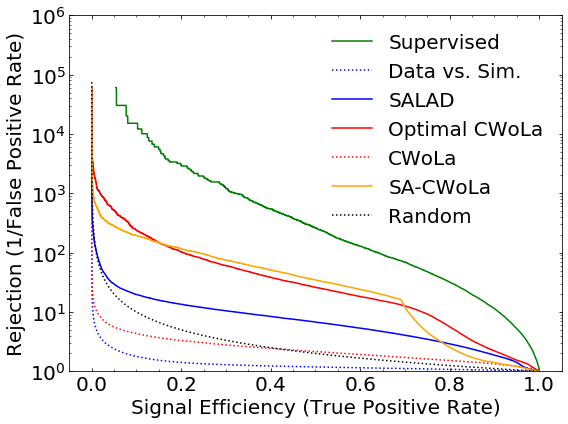

In [587]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(tpr_fully,1./fpr_fully,label="Supervised",color="green")
plt.plot(tpr_datavsim,1./fpr_datavsim,label="Data vs. Sim.",color="blue",ls=":")
plt.plot(tpr_salad,1./fpr_salad,label="SALAD",color="blue")
plt.plot(tpr_ocwola,1./fpr_ocwola,label="Optimal CWoLa",color="red")
plt.plot(tpr_cwola,1./fpr_cwola,label="CWoLa",color="red",ls=":")
plt.plot(tpr_sacwola,1./fpr_sacwola,label="SA-CWoLa",color="orange")
#plt.plot(tprSB_cwola,1./fprSB_cwola,label="CWoLa (SR vs. SB)",color="orange",ls=':')
plt.plot(tpr_fully,1./tpr_fully,color="black",ls=":",label="Random")
plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=20,loc="upper right")
plt.yscale("log")
plt.ylim([1,1e6])
plt.tight_layout()
plt.savefig('SA-CWoLa/roc_shifted.pdf',bbox_inches='tight')

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:14: Runtim

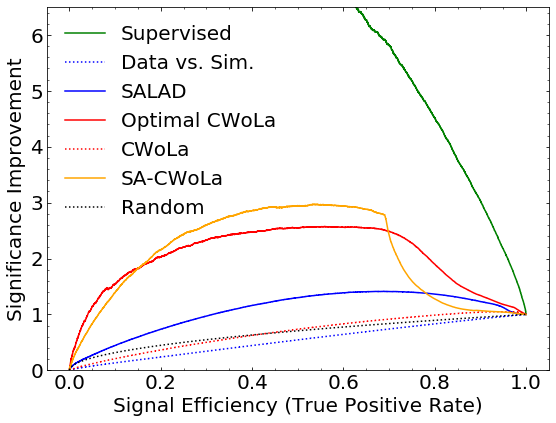

In [194]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(tpr_fully,tpr_fully/fpr_fully**0.5,label="Supervised",color="green")
plt.plot(tpr_datavsim,tpr_datavsim/fpr_datavsim**0.5,label="Data vs. Sim.",color="blue",ls=":")
plt.plot(tpr_salad,tpr_salad/fpr_salad**0.5,label="SALAD",color="blue")
plt.plot(tpr_ocwola,tpr_ocwola/fpr_ocwola**0.5,label="Optimal CWoLa",color="red")
plt.plot(tpr_cwola,tpr_cwola/fpr_cwola**0.5,label="CWoLa",color="red",ls=":")
plt.plot(tpr_sacwola,tpr_sacwola/fpr_sacwola**0.5,label="SA-CWoLa",color="orange")
#plt.plot(tprSB_cwola,1./fprSB_cwola,label="CWoLa (SR vs. SB)",color="orange",ls=':')
plt.plot(tpr_fully,tpr_fully/tpr_fully**0.5,color="black",ls=":",label="Random")
plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Significance Improvement",fontsize=20)
plt.legend(frameon=False,fontsize=20,loc="upper left")
plt.tight_layout()
plt.ylim([0,6.5])
plt.savefig('SA-CWoLa/sic_shifted.pdf',bbox_inches='tight')

In [214]:
#Now, a lambda scan, with signal

SR_low = 3.3
SR_high = 3.7

X_sig_inject = dataset_sig_shifted[0:500]
X_sig_inject2 = dataset_sig_shifted[500:1000]
X_sig_test = dataset_sig_shifted[500:-1]
X_bg_SR = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,1:5]
X_bg_SR_train = X_bg_SR[0:int(0.5*len(X_bg_SR))]
X_bg_SR_test = X_bg_SR[int(0.5*len(X_bg_SR)):-1]
X_bg2_SR = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,1:5]
X_bg2_SR_train = X_bg2_SR[0:int(0.5*len(X_bg2_SR))]
X_bg2_SR_test = X_bg2_SR[int(0.5*len(X_bg2_SR)):-1]
X_sig_SR_train = X_sig_inject[(X_sig_inject[:,0] > SR_low)*(X_sig_inject[:,0] < SR_high)][:,1:5]
X_sig_SR_test = X_sig_test[(X_sig_test[:,0] > SR_low)*(X_sig_test[:,0] < SR_high)][:,1:5]

SB_low = 3.1
SB_high = 3.9

X_background_inject = dataset_bg_shifted[0:int(0.5*len(dataset_bg))]
X_sig_SB_low = X_sig_inject[(X_sig_inject[:,0] > SB_low)*(X_sig_inject[:,0] < SR_low)][:,1:5]
X_bg_SB_low = X_background_inject[(X_background_inject[:,0] > SB_low)*(X_background_inject[:,0] < SR_low)][:,1:5]
X_sig_SB_high = X_sig_inject[(X_sig_inject[:,0] > SR_high)*(X_sig_inject[:,0] < SB_high)][:,1:5]
X_bg_SB_high = X_background_inject[(X_background_inject[:,0] > SR_high)*(X_background_inject[:,0] < SB_high)][:,1:5]

X_background_fortest = dataset_bg_shifted[int(0.5*len(dataset_bg)):-1]
X_sig_SB_low_test = X_sig_inject2[(X_sig_inject2[:,0] > SB_low)*(X_sig_inject2[:,0] < SR_low)][:,1:5]
X_bg_SB_low_test = X_background_fortest[(X_background_fortest[:,0] > SB_low)*(X_background_fortest[:,0] < SR_low)][:,1:5]
X_sig_SB_high_test = X_sig_inject2[(X_sig_inject2[:,0] > SR_high)*(X_sig_inject2[:,0] < SB_high)][:,1:5]
X_bg_SB_high_test = X_background_fortest[(X_background_fortest[:,0] > SR_high)*(X_background_fortest[:,0] < SB_high)][:,1:5]

X_test = np.concatenate([X_sig_SR_test,X_bg_SR_test])
Y_test = np.concatenate([np.ones(len(X_sig_SR_test)),np.zeros(len(X_bg_SR_test))])

lambdas = []
max_sic = []
aucs = []
maxSB_sic = []
aucsSB = []

#mylambda = 0.5
for mylambda in np.linspace(0,1,20):
    
    model_sacwola_scan = Sequential()
    model_sacwola_scan.add(Dense(64, input_dim=4, activation='relu')) 
    model_sacwola_scan.add(Dense(64, activation='relu'))
    model_sacwola_scan.add(Dense(64, activation='relu'))
    model_sacwola_scan.add(Dense(1, activation='sigmoid'))
    model_sacwola_scan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    X_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low,X_bg_SB_low,X_sig_SB_high,X_bg_SB_high,
                             X_bg2_SR_train,X_bg2_SB_low,X_bg2_SB_high])
    Y_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low)),np.zeros(len(X_bg_SB_low)),np.zeros(len(X_sig_SB_high)),np.zeros(len(X_bg_SB_high)),
                             np.ones(len(X_bg2_SR_train)),np.zeros(len(X_bg2_SB_low)),np.zeros(len(X_bg2_SB_high))])
    w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low)+len(X_bg_SB_low))
    w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high)+len(X_bg_SB_high))
    w2_low = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_low)+len(X_bg2_SB_low))
    w2_high = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_high)+len(X_bg2_SB_high))
    W_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low)),w_low*np.ones(len(X_bg_SB_low)),w_high*np.ones(len(X_sig_SB_high)),w_high*np.ones(len(X_bg_SB_high)),
                             -mylambda*np.ones(len(X_bg2_SR_train)),-mylambda*w_low*np.ones(len(X_bg2_SB_low)),-mylambda*w_high*np.ones(len(X_bg2_SB_high))])

    X_testSB = np.concatenate([X_bg_SR_train,X_bg_SB_low_test,X_bg_SB_high_test])
    Y_testSB = np.concatenate([np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg_SB_low_test)),np.zeros(len(X_bg_SB_high_test))])
    w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_bg_SB_low_test))
    w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_bg_SB_high_test))
    W_testSB = np.concatenate([np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_bg_SB_low_test)),w_high*np.ones(len(X_bg_SB_high_test))])

    model_sacwola_scan.fit(X_train,Y_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test),sample_weight=W_train)

    preds_hold = model_sacwola_scan.predict(X_test,batch_size=10000)[:,0]
    preds_holdSB = model_sacwola_scan.predict(X_testSB,batch_size=10000)[:,0]
    fpr_sacwola_scan, tpr_sacwola_scan, _ = roc_curve(Y_test, preds_hold)
    fprSB_sacwola_scan, tprSB_sacwola_scan, _ = roc_curve(Y_testSB, preds_holdSB, sample_weight=W_testSB)
    myauc_scan = roc_auc_score(Y_test, preds_hold)
    myaucSB_scan = roc_auc_score(Y_testSB, preds_holdSB)

    lambdas += [mylambda]
    max_sic += [max(tpr_sacwola_scan/(0.000001+fpr_sacwola_scan)**0.5)]
    aucs += [myauc_scan]
    maxSB_sic += [max(tprSB_sacwola_scan/(0.000001+fprSB_sacwola_scan)**0.5)]
    aucsSB += [myaucSB_scan]

Train on 252674 samples, validate on 135581 samples
Epoch 1/10
252674/252674 [==============================] - 16s 61us/step - loss: 0.6718 - acc: 0.5036 - val_loss: 0.6970 - val_acc: 0.4475
Epoch 2/10
252674/252674 [==============================] - 11s 42us/step - loss: 0.6716 - acc: 0.5015 - val_loss: 0.6969 - val_acc: 0.3518
Epoch 3/10
252674/252674 [==============================] - 10s 41us/step - loss: 0.6703 - acc: 0.5110 - val_loss: 0.6870 - val_acc: 0.5660
Epoch 4/10
252674/252674 [==============================] - 11s 42us/step - loss: 0.6633 - acc: 0.5362 - val_loss: 0.6888 - val_acc: 0.6039
Epoch 5/10
252674/252674 [==============================] - 11s 42us/step - loss: 0.6601 - acc: 0.5359 - val_loss: 0.6796 - val_acc: 0.5963
Epoch 6/10
252674/252674 [==============================] - 10s 40us/step - loss: 0.6588 - acc: 0.5357 - val_loss: 0.6840 - val_acc: 0.5800
Epoch 7/10
252674/252674 [==============================] - 10s 41us/step - loss: 0.6579 - acc: 0.5368 - val

252674/252674 [==============================] - 11s 43us/step - loss: 0.2463 - acc: 0.5018 - val_loss: 0.6828 - val_acc: 0.5525
Epoch 8/10
252674/252674 [==============================] - 11s 42us/step - loss: 0.2463 - acc: 0.4984 - val_loss: 0.6840 - val_acc: 0.7496
Epoch 9/10
252674/252674 [==============================] - 10s 41us/step - loss: 0.2463 - acc: 0.5005 - val_loss: 0.6745 - val_acc: 0.8162
Epoch 10/10
252674/252674 [==============================] - 11s 42us/step - loss: 0.2463 - acc: 0.5063 - val_loss: 0.6671 - val_acc: 0.8461
Train on 252674 samples, validate on 135581 samples
Epoch 1/10
252674/252674 [==============================] - 16s 63us/step - loss: 0.2286 - acc: 0.4954 - val_loss: 0.6894 - val_acc: 0.5525
Epoch 2/10
252674/252674 [==============================] - 11s 42us/step - loss: 0.2286 - acc: 0.4927 - val_loss: 0.6871 - val_acc: 0.5525
Epoch 3/10
252674/252674 [==============================] - 11s 42us/step - loss: 0.2286 - acc: 0.4962 - val_loss: 0.6

252674/252674 [==============================] - 11s 43us/step - loss: 0.1398 - acc: 0.4915 - val_loss: 0.6861 - val_acc: 0.8089
Epoch 4/10
252674/252674 [==============================] - 11s 43us/step - loss: 0.1398 - acc: 0.4951 - val_loss: 0.6682 - val_acc: 0.5525
Epoch 5/10
252674/252674 [==============================] - 11s 43us/step - loss: 0.1398 - acc: 0.4924 - val_loss: 0.6735 - val_acc: 0.5525
Epoch 6/10
252674/252674 [==============================] - 10s 41us/step - loss: 0.1398 - acc: 0.4904 - val_loss: 0.6768 - val_acc: 0.5671
Epoch 7/10
252674/252674 [==============================] - 11s 43us/step - loss: 0.1397 - acc: 0.4954 - val_loss: 0.6802 - val_acc: 0.6240
Epoch 8/10
252674/252674 [==============================] - 11s 43us/step - loss: 0.1396 - acc: 0.4944 - val_loss: 0.6349 - val_acc: 0.5526
Epoch 9/10
252674/252674 [==============================] - 11s 43us/step - loss: 0.1396 - acc: 0.4885 - val_loss: 0.5983 - val_acc: 0.6016
Epoch 10/10
252674/252674 [====

252674/252674 [==============================] - 11s 44us/step - loss: -0.0958 - acc: 0.4832 - val_loss: 1.0449 - val_acc: 0.7516
Epoch 10/10
252674/252674 [==============================] - 11s 43us/step - loss: -0.0999 - acc: 0.4813 - val_loss: 1.4304 - val_acc: 0.5547
Train on 252674 samples, validate on 135581 samples
Epoch 1/10
252674/252674 [==============================] - 18s 72us/step - loss: 0.0334 - acc: 0.4852 - val_loss: 0.6554 - val_acc: 0.5525
Epoch 2/10
252674/252674 [==============================] - 11s 44us/step - loss: -0.0041 - acc: 0.4911 - val_loss: 1.1036 - val_acc: 0.7889
Epoch 3/10
252674/252674 [==============================] - 11s 42us/step - loss: -0.1083 - acc: 0.4910 - val_loss: 1.7212 - val_acc: 0.8016
Epoch 4/10
252674/252674 [==============================] - 11s 44us/step - loss: -0.1336 - acc: 0.4896 - val_loss: 3.5911 - val_acc: 0.5525
Epoch 5/10
252674/252674 [==============================] - 11s 44us/step - loss: -0.1459 - acc: 0.4848 - val_los

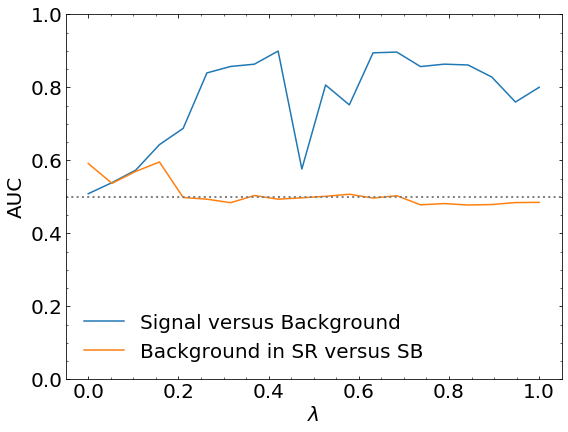

In [228]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(lambdas,aucs,label="Signal versus Background")
plt.plot(lambdas,aucsSB,label="Background in SR versus SB")
plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'$\lambda$',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])
plt.savefig('SA-CWoLa/lambdascan_AUC.pdf',bbox_inches='tight')

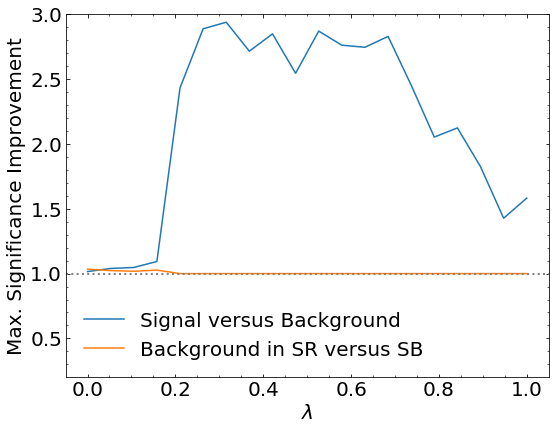

In [234]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(lambdas,max_sic,label="Signal versus Background")
plt.plot(lambdas,maxSB_sic,label="Background in SR versus SB")
plt.axhline(1.,linewidth=2, color='gray',ls=":")

plt.xlabel(r'$\lambda$',fontsize=20)
plt.ylabel(r"Max. Significance Improvement",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0.2,3])
plt.savefig('SA-CWoLa/lambdascan_sic.pdf',bbox_inches='tight')

In [582]:
#Now, a lambda scan, without signal

'''
SR_low = 3.3
SR_high = 3.7

X_sig_inject = dataset_sig_shifted[0:1]
X_sig_inject2 = dataset_sig_shifted[1:2]
X_sig_test = dataset_sig_shifted[500:-1]
X_bg_SR = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,1:5]
X_bg_SR_train = X_bg_SR[0:int(0.5*len(X_bg_SR))]
X_bg_SR_test = X_bg_SR[int(0.5*len(X_bg_SR)):-1]
X_bg2_SR = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,1:5]
X_bg2_SR_train = X_bg2_SR[0:int(0.5*len(X_bg2_SR))]
X_bg2_SR_test = X_bg2_SR[int(0.5*len(X_bg2_SR)):-1]
X_sig_SR_train = X_sig_inject[(X_sig_inject[:,0] > SR_low)*(X_sig_inject[:,0] < SR_high)][:,1:5]
X_sig_SR_test = X_sig_test[(X_sig_test[:,0] > SR_low)*(X_sig_test[:,0] < SR_high)][:,1:5]

SB_low = 3.1
SB_high = 3.9

X_background_inject = dataset_bg_shifted[0:int(0.5*len(dataset_bg))]
X_sig_SB_low = X_sig_inject[(X_sig_inject[:,0] > SB_low)*(X_sig_inject[:,0] < SR_low)][:,1:5]
X_bg_SB_low = X_background_inject[(X_background_inject[:,0] > SB_low)*(X_background_inject[:,0] < SR_low)][:,1:5]
X_sig_SB_high = X_sig_inject[(X_sig_inject[:,0] > SR_high)*(X_sig_inject[:,0] < SB_high)][:,1:5]
X_bg_SB_high = X_background_inject[(X_background_inject[:,0] > SR_high)*(X_background_inject[:,0] < SB_high)][:,1:5]

X_background_fortest = dataset_bg_shifted[int(0.5*len(dataset_bg)):-1]
X_sig_SB_low_test = X_sig_inject2[(X_sig_inject2[:,0] > SB_low)*(X_sig_inject2[:,0] < SR_low)][:,1:5]
X_bg_SB_low_test = X_background_fortest[(X_background_fortest[:,0] > SB_low)*(X_background_fortest[:,0] < SR_low)][:,1:5]
X_sig_SB_high_test = X_sig_inject2[(X_sig_inject2[:,0] > SR_high)*(X_sig_inject2[:,0] < SB_high)][:,1:5]
X_bg_SB_high_test = X_background_fortest[(X_background_fortest[:,0] > SR_high)*(X_background_fortest[:,0] < SB_high)][:,1:5]

X_test = np.concatenate([X_sig_SR_test,X_bg_SR_test])
Y_test = np.concatenate([np.ones(len(X_sig_SR_test)),np.zeros(len(X_bg_SR_test))])

lambdas_NO = []
max_sic_NO = []
aucs_NO = []
maxSB_sic_NO = []
aucsSB_NO = []

#mylambda = 0.5
for mylambda in np.linspace(0,1,20):
    
    model_sacwola_scan = Sequential()
    model_sacwola_scan.add(Dense(64, input_dim=4, activation='relu')) 
    model_sacwola_scan.add(Dense(64, activation='relu'))
    model_sacwola_scan.add(Dense(64, activation='relu'))
    model_sacwola_scan.add(Dense(1, activation='sigmoid'))
    model_sacwola_scan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    X_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low,X_bg_SB_low,X_sig_SB_high,X_bg_SB_high,
                             X_bg2_SR_train,X_bg2_SB_low,X_bg2_SB_high])
    Y_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low)),np.zeros(len(X_bg_SB_low)),np.zeros(len(X_sig_SB_high)),np.zeros(len(X_bg_SB_high)),
                             np.ones(len(X_bg2_SR_train)),np.zeros(len(X_bg2_SB_low)),np.zeros(len(X_bg2_SB_high))])
    w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low)+len(X_bg_SB_low))
    w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high)+len(X_bg_SB_high))
    w2_low = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_low)+len(X_bg2_SB_low))
    w2_high = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_high)+len(X_bg2_SB_high))
    W_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low)),w_low*np.ones(len(X_bg_SB_low)),w_high*np.ones(len(X_sig_SB_high)),w_high*np.ones(len(X_bg_SB_high)),
                             -mylambda*np.ones(len(X_bg2_SR_train)),-mylambda*w_low*np.ones(len(X_bg2_SB_low)),-mylambda*w_high*np.ones(len(X_bg2_SB_high))])

    X_testSB = np.concatenate([X_bg_SR_train,X_bg_SB_low_test,X_bg_SB_high_test])
    Y_testSB = np.concatenate([np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg_SB_low_test)),np.zeros(len(X_bg_SB_high_test))])
    w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_bg_SB_low_test))
    w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_bg_SB_high_test))
    W_testSB = np.concatenate([np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_bg_SB_low_test)),w_high*np.ones(len(X_bg_SB_high_test))])

    model_sacwola_scan.fit(X_train,Y_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test),sample_weight=W_train)

    preds_hold = model_sacwola_scan.predict(X_test,batch_size=10000)[:,0]
    preds_holdSB = model_sacwola_scan.predict(X_testSB,batch_size=10000)[:,0]
    fpr_sacwola_scan, tpr_sacwola_scan, _ = roc_curve(Y_test, preds_hold)
    fprSB_sacwola_scan, tprSB_sacwola_scan, _ = roc_curve(Y_testSB, preds_holdSB, sample_weight=W_testSB)
    myauc_scan = roc_auc_score(Y_test, preds_hold)
    myaucSB_scan = roc_auc_score(Y_testSB, preds_holdSB)

    lambdas_NO += [mylambda]
    max_sic_NO += [max(tpr_sacwola_scan/(0.000001+fpr_sacwola_scan)**0.5)]
    aucs_NO += [myauc_scan]
    maxSB_sic_NO += [max(tprSB_sacwola_scan/(0.000001+fprSB_sacwola_scan)**0.5)]
    aucsSB_NO += [myaucSB_scan]
'''

"\nSR_low = 3.3\nSR_high = 3.7\n\nX_sig_inject = dataset_sig_shifted[0:1]\nX_sig_inject2 = dataset_sig_shifted[1:2]\nX_sig_test = dataset_sig_shifted[500:-1]\nX_bg_SR = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,1:5]\nX_bg_SR_train = X_bg_SR[0:int(0.5*len(X_bg_SR))]\nX_bg_SR_test = X_bg_SR[int(0.5*len(X_bg_SR)):-1]\nX_bg2_SR = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,1:5]\nX_bg2_SR_train = X_bg2_SR[0:int(0.5*len(X_bg2_SR))]\nX_bg2_SR_test = X_bg2_SR[int(0.5*len(X_bg2_SR)):-1]\nX_sig_SR_train = X_sig_inject[(X_sig_inject[:,0] > SR_low)*(X_sig_inject[:,0] < SR_high)][:,1:5]\nX_sig_SR_test = X_sig_test[(X_sig_test[:,0] > SR_low)*(X_sig_test[:,0] < SR_high)][:,1:5]\n\nSB_low = 3.1\nSB_high = 3.9\n\nX_background_inject = dataset_bg_shifted[0:int(0.5*len(dataset_bg))]\nX_sig_SB_low = X_sig_inject[(X_sig_inject[:,0] > SB_low)*(X_sig_inject[:,0] < SR_low)][:,1:5]\nX_bg_SB_low = X_background

In [583]:
#plt.plot(lambdas,aucs_NO)
#plt.plot(lambdas,aucsSB_NO)

In [584]:
#plt.plot(lambdas,max_sic_NO)
#plt.plot(lambdas,maxSB_sic_NO)

In [315]:
#Try a fit.

In [271]:
from ATLAS_anomaly_detection.fit_utils import *

In [442]:
n,b=np.histogram(np.concatenate([1000*dataset_bg[int(0.5*len(dataset_bg)):-1][:,0],1000*dataset_sig[:,0][0:0]]),np.linspace(2600,5000,30))

In [443]:
myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
#myout = get_fit_params(n,b,n**0.5,[28],verbose=False,npar=4)

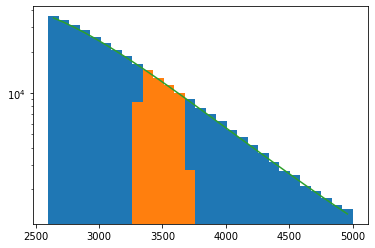

In [444]:
_,_,_=plt.hist(1000*dataset_bg[int(0.5*len(dataset_bg)):-1][:,0],np.linspace(2600,5000,30))
_,_,_=plt.hist(1000*dataset_bg[int(0.5*len(dataset_bg)):-1][:,0][(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0] > SR_low)*(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0] < SR_high)],np.linspace(2600,5000,30))
plt.plot(0.5*(b[ 1:]+b[:-1]) ,80*myout['ydata_fit']/100)
plt.yscale("log")

In [445]:
#myout

In [446]:
print("mean",np.mean(myout['residuals']))
print("std",np.std(myout['residuals']))

mean -0.10745200516651034
std 1.2487176603437526


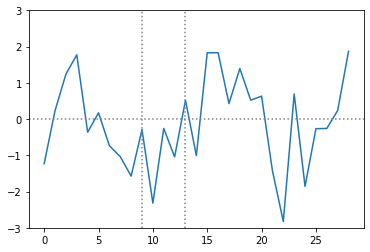

In [447]:
plt.plot(myout['residuals'])
plt.ylim([-3,3])
plt.axhline(y=0,color="gray",ls=":")
plt.axvline(x=9,color="gray",ls=":")
plt.axvline(x=13,color="gray",ls=":")

mean -0.011794759525631658
std 0.12457789130384485


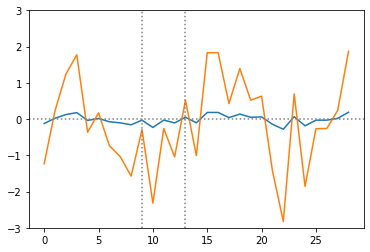

In [456]:
n2 = n-0.9*myout['residuals']*n**0.5
myout2 = get_fit_params(n2,b,n**0.5,range(9,14),verbose=False)
print("mean",np.mean(myout2['residuals']))
print("std",np.std(myout2['residuals']))
plt.plot(myout2['residuals'])
plt.plot(myout['residuals'])
plt.ylim([-3,3])
plt.axhline(y=0,color="gray",ls=":")
plt.axvline(x=9,color="gray",ls=":")
plt.axvline(x=13,color="gray",ls=":")

In [344]:
myout['Zval']

14.621732407416205

In [464]:
fitvals = []
injectvals = []
n,b=np.histogram(1000*dataset_bg[int(0.5*len(dataset_bg)):-1][:,0],np.linspace(2600,5000,30))
myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
mycor = myout['residuals']*n**0.5
for s in np.linspace(0,10,20):
    mult = 310.
    B = len(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0][(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0] > SR_low)*(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0] < SR_high)])
    S = len(dataset_sig[0:int(s*mult)][:,0][(dataset_sig[0:int(s*mult)][:,0] > SR_low)*(dataset_sig[0:int(s*mult)][:,0] < SR_high)])
    n,b=np.histogram(np.concatenate([1000*dataset_bg[int(0.5*len(dataset_bg)):-1][:,0],1000*dataset_sig[0:int(s*mult)][:,0]]),np.linspace(2600,5000,30))
    n = n - 0.99*mycor
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    print(s,S/B**0.5,myout['Zval'])
    injectvals+=[S/B**0.5]
    fitvals+=[myout['Zval']]

0.0 0.0 0
0.5263157894736842 0.5291026764197476 0.359294514998764
1.0526315789473684 1.0297152087245858 0.6802287360114024
1.5789473684210527 1.5547478645564892 1.037880111620629
2.1052631578947367 2.0919905821519253 1.3992062018813978
2.631578947368421 2.5600429497540094 1.69739340692387
3.1578947368421053 3.07286554382238 2.040212149385334
3.6842105263157894 3.569408055539374 2.3516015322034423
4.2105263157894735 4.070020587844212 2.681377100351293
4.7368421052631575 4.578773161324738 3.020208736928717
5.263157894736842 5.059035590690356 3.352729038771005
5.789473684210526 5.551508081819506 3.68543387300056
6.315789473684211 6.052120614124344 4.021770425754249
6.842105263157895 6.552733146429182 4.3829631946055585
7.368421052631579 7.028925555206954 4.753617824708458
7.894736842105263 7.5458181698631694 5.146978684316785
8.421052631578947 8.034220640404476 5.497318566201309
8.947368421052632 8.53076315212147 5.852564643866494
9.473684210526315 9.063935849129061 6.277236992555623
10.0

Text(0, 0.5, 'Fitted significance')

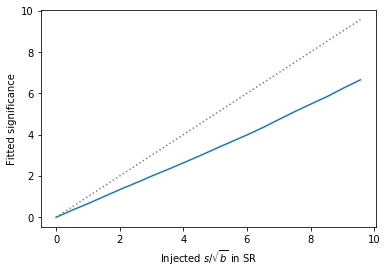

In [466]:
plt.plot(injectvals,fitvals)
plt.plot(injectvals,injectvals,ls=":",color="gray")
plt.xlabel(r"Injected $s/\sqrt{b}$ in SR")
plt.ylabel(r"Fitted significance")

In [556]:
X_sig_test_all = dataset_sig_shifted[500:2000]
X_sig_SR_test_all = X_sig_test_all[:,1:5]
M_sig_SR_test_all = X_sig_test_all[:,0]
X_bg_SR_all = dataset_bg_shifted[:,0:5]
X_bg_SR_test_all = X_bg_SR_all[int(0.5*len(X_bg_SR)):-1][:,1:5]
M_bg_SR_test_all = X_bg_SR_all[int(0.5*len(X_bg_SR)):-1][:,0]

X_test_all = np.concatenate([X_sig_SR_test_all,X_bg_SR_test_all])
Y_test_all = np.concatenate([np.ones(len(X_sig_SR_test_all)),np.zeros(len(X_bg_SR_test_all))])
M_test_all = np.concatenate([M_sig_SR_test_all,M_bg_SR_test_all])

In [591]:
preds_fully_all = model.predict(X_test_all,batch_size=10000)
preds_optimal_cwola = model_cwola_optimal.predict(X_test_all,batch_size=10000)
preds_sacwola = model_sacwola.predict(X_test_all,batch_size=10000)
preds_cwola = model_cwola.predict(X_test_all,batch_size=10000)
preds_salad = model_salad.predict(X_test_all,batch_size=10000)
preds_datavsim = model_datavsim.predict(X_test_all,batch_size=10000)

(array([2.86111747e+02, 2.92403764e+01, 6.46073920e+00, 3.77507768e+00,
        2.15907173e+00, 1.19450966e+00, 6.53654342e-01, 3.01582349e-01,
        1.50430040e-01, 8.88271051e-02]),
 array([0.4990368 , 0.50206584, 0.50509495, 0.508124  , 0.5111531 ,
        0.51418215, 0.5172112 , 0.5202403 , 0.52326936, 0.52629846,
        0.5293275 ], dtype=float32),
 <a list of 10 Patch objects>)

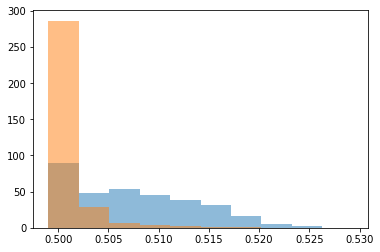

In [558]:
n,b,_=plt.hist(preds_optimal_cwola[Y_test_all==1][:,0],density=True,alpha=0.5)
plt.hist(preds_optimal_cwola[Y_test_all==0][:,0],density=True,bins=b,alpha=0.5)

(array([1.65854428e-02, 3.22358272e+01, 8.82092280e-01, 2.77121396e-01,
        1.74507526e-01, 1.09211425e-01, 7.27957452e-02, 4.67276352e-02,
        2.91327202e-02, 1.48547729e-02]),
 array([0.44259465, 0.47212902, 0.5016634 , 0.5311978 , 0.5607321 ,
        0.5902665 , 0.6198009 , 0.64933527, 0.67886966, 0.708404  ,
        0.7379384 ], dtype=float32),
 <a list of 10 Patch objects>)

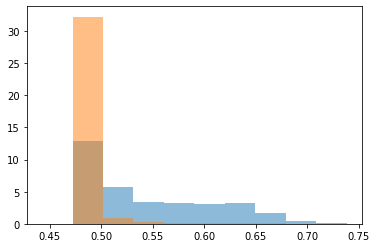

In [592]:
n,b,_=plt.hist(preds_sacwola[Y_test_all==1][:,0],density=True,alpha=0.5)
plt.hist(preds_sacwola[Y_test_all==0][:,0],density=True,bins=b,alpha=0.5)

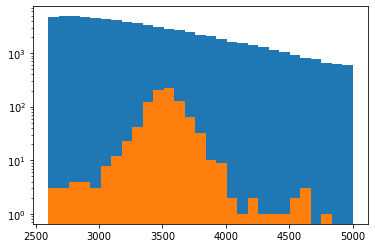

In [559]:
q = np.quantile(preds_optimal_cwola[Y_test_all==0],0.9)
plt.hist(1000*M_test_all[(Y_test_all==0) * (preds_optimal_cwola[:,0]>q)],np.linspace(2600,5000,30))
plt.hist(1000*M_test_all[(Y_test_all==1) * (preds_optimal_cwola[:,0]>q)],np.linspace(2600,5000,30))
plt.yscale('log')

In [608]:
cutval = []
sigval_fit = []
sigval_fit_sacwola = []
sigval_fit_cwola = []
sigval_fit_salad = []
sigval_fit_datavsim = []
sigval = []
for myqexp in range(20):
    myq = 1.-2**(-myqexp/2)
    if (myq==0):
        myq = 0.01
    q = np.quantile(preds_optimal_cwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_optimal_cwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-0.*myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    
    B = len(M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    S = len(M_test_all[(Y_test_all==1)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    
    cutval+=[2**(-myqexp)] #myq]
    sigval_fit+=[myout['Zval']]
    sigval+=[S/B**0.5]
    
    q = np.quantile(preds_sacwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_sacwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_sacwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-0.*myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval_fit_sacwola+=[myout['Zval']]
    
    q = np.quantile(preds_salad[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_salad[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_salad[:,0]>q],np.linspace(2600,5000,30))
    n = n-0.*myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval_fit_salad+=[myout['Zval']]    
    
    '''
    q = np.quantile(preds_datavsim[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_datavsim[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_datavsim[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval_fit_datavsim+=[myout['Zval']]  
    '''
    
    '''
    q = np.quantile(preds_cwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_cwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_cwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval_fit_cwola+=[myout['Zval']]     
    '''
    
    print(myq,myout['Zval'],myout['p0'],S/B**0.5)

0.01 0.19539451069420974 0.4225420568123017 2.9083435479395763
0.2928932188134524 0.7692304372115132 0.22087826224595797 3.3256735856228468
0.5 0.15491006576545446 0.43844610905540815 3.8021203928719403
0.6464466094067263 0.760364129948985 0.22351847910326406 4.2088517867248445
0.75 1.2523414870795433 0.10522272883865247 4.67146184535331
0.8232233047033631 1.433827255079023 0.07581078257094609 5.237136012325416
0.875 0.7505952675681486 0.22644813504936145 5.702474041826996
0.9116116523516815 0.12282654287840687 0.4511222276116551 6.224679638566222
0.9375 0.07366103394637555 0.470640052462748 6.604284111654417
0.9558058261758408 0 0.5 6.855711541605629
0.96875 0 0.5 6.7454720188923885
0.9779029130879204 0 0.5 6.593776630308277
0.984375 0 0.5 6.237306118133428
0.9889514565439602 0 0.5 6.034080306244444
0.9921875 0 0.5 5.410837270310642
0.99447572827198 0 0.5 4.610694459770735
0.99609375 0.03706979751280231 0.48521467678140795 3.7923637051198176
0.99723786413599 0.6083198442331808 0.27148

/home/bpnachman/DCTRHunting/ATLAS_anomaly_detection/fit_utils.py:158: RuntimeWarning: divide by zero encountered in true_divide
  res_unc = 1 / np.sqrt(ydata)
/home/bpnachman/DCTRHunting/ATLAS_anomaly_detection/fit_utils.py:158: RuntimeWarning: divide by zero encountered in true_divide
  res_unc = 1 / np.sqrt(ydata)


0.998618932067995 1.2977877484775326 0.09718014037430422 1.4184162865339505


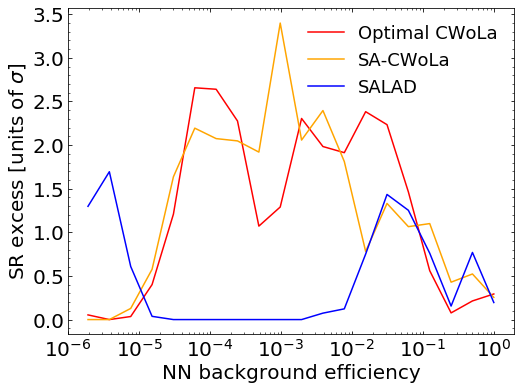

In [634]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(cutval,sigval_fit,label="Optimal CWoLa",color='red')
plt.plot(cutval,sigval_fit_sacwola,label="SA-CWoLa",color='orange')
plt.plot(cutval,sigval_fit_salad,label="SALAD",color='blue')
#plt.plot(cutval,sigval)
plt.xscale("log")
plt.legend(frameon=False,fontsize=18)

plt.xlabel("NN background efficiency",fontsize=20)
plt.ylabel("SR excess [units of $\sigma$]",fontsize=20)
plt.savefig('SA-CWoLa/fitwithsig.pdf',bbox_inches='tight')

In [612]:
cutval = []
sigval2_fit = []
sigval2_fit_sacwola = []
sigval2_fit_cwola = []
sigval2_fit_salad = []
sigval2_fit_datavsim = []
sigval2 = []
for myqexp in range(20):
    myq = 1.-2**(-myqexp/2)
    if (myq==0):
        myq = 0.01
    q = np.quantile(preds_optimal_cwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_optimal_cwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    
    B = len(M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    S = len(M_test_all[(Y_test_all==1)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    
    cutval+=[2**(-myqexp)] #myq]
    sigval2_fit+=[myout['Zval']]
    sigval+=[S/B**0.5]
    
    q = np.quantile(preds_sacwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_sacwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_sacwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval2_fit_sacwola+=[myout['Zval']]
    
    q = np.quantile(preds_salad[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_salad[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_salad[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval2_fit_salad+=[myout['Zval']]    
    
    '''
    q = np.quantile(preds_datavsim[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_datavsim[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_datavsim[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval2_fit_datavsim+=[myout['Zval']]  
    '''
    
    '''
    q = np.quantile(preds_cwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_cwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_cwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval2_fit_cwola+=[myout['Zval']]     
    '''
    
    print(myq,myout['Zval'],myout['p0'],S/B**0.5)

0.01 1.932819603549976 0.02662921226350312 2.9083435479395763
0.2928932188134524 2.087731013439773 0.018411052801382888 3.3256735856228468
0.5 2.317960410198323 0.010225736385442996 3.8021203928719403
0.6464466094067263 2.4983835959235234 0.006238055453561597 4.2088517867248445
0.75 2.6589719528428835 0.003918974379296447 4.67146184535331
0.8232233047033631 2.6819511478284217 0.0036597073752835385 5.237136012325416
0.875 2.652868464720171 0.0039905482802721215 5.702474041826996
0.9116116523516815 2.3712865244390002 0.008863141688144505 6.224679638566222
0.9375 1.9936449073961247 0.023095437020309362 6.604284111654417
0.9558058261758408 1.3534950469205274 0.08794876566163623 6.855711541605629
0.96875 0.9496588663345475 0.17114280844906005 6.7454720188923885
0.9779029130879204 0.6300728100883621 0.26432347408101087 6.593776630308277
0.984375 0.3298502149800089 0.37075657133961226 6.237306118133428
0.9889514565439602 0.2325473705440609 0.40805644953550146 6.034080306244444
0.9921875 0.134

/home/bpnachman/DCTRHunting/ATLAS_anomaly_detection/fit_utils.py:158: RuntimeWarning: divide by zero encountered in true_divide
  res_unc = 1 / np.sqrt(ydata)
/home/bpnachman/DCTRHunting/ATLAS_anomaly_detection/fit_utils.py:158: RuntimeWarning: divide by zero encountered in true_divide
  res_unc = 1 / np.sqrt(ydata)


0.998618932067995 0 0.5 1.4184162865339505


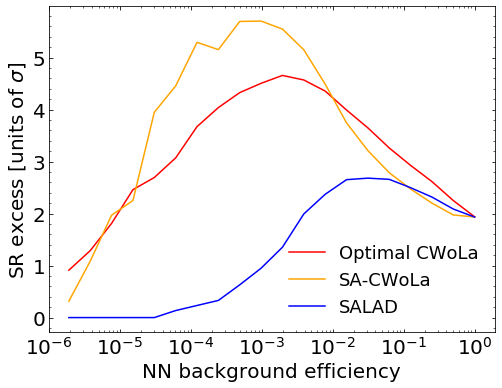

In [633]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(cutval,sigval2_fit,label="Optimal CWoLa",color='red')
plt.plot(cutval,sigval2_fit_sacwola,label="SA-CWoLa",color='orange')
plt.plot(cutval,sigval2_fit_salad,label="SALAD",color='blue')
#plt.plot(cutval,sigval)
plt.xscale("log")
plt.legend(frameon=False,fontsize=18)

plt.xlabel("NN background efficiency",fontsize=20)
plt.ylabel("SR excess [units of $\sigma$]",fontsize=20)
plt.savefig('SA-CWoLa/fitwithsig_optimal.pdf',bbox_inches='tight')

In [ ]:
#Now, do a training with no signal and run the same fit?

In [616]:
#CWoLa
model_sacwola_NO = Sequential()
model_sacwola_NO.add(Dense(64, input_dim=4, activation='relu')) 
model_sacwola_NO.add(Dense(64, activation='relu'))
model_sacwola_NO.add(Dense(64, activation='relu'))
model_sacwola_NO.add(Dense(1, activation='sigmoid'))
model_sacwola_NO.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

SR_low = 3.3
SR_high = 3.7

X_bg_SR = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,1:5]
X_bg_SR_train = X_bg_SR[0:int(0.5*len(X_bg_SR))]
X_bg2_SR = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,1:5]
X_bg2_SR_train = X_bg2_SR[0:int(0.5*len(X_bg2_SR))]
X_sig_SR_train = X_sig_inject[(X_sig_inject[:,0] > SR_low)*(X_sig_inject[:,0] < SR_high)][:,1:5]

SB_low = 3.1
SB_high = 3.9

X_background_inject = dataset_bg_shifted[0:int(0.5*len(dataset_bg))]
X_sig_SB_low = X_sig_inject[(X_sig_inject[:,0] > SB_low)*(X_sig_inject[:,0] < SR_low)][:,1:5]
X_bg_SB_low = X_background_inject[(X_background_inject[:,0] > SB_low)*(X_background_inject[:,0] < SR_low)][:,1:5]
X_sig_SB_high = X_sig_inject[(X_sig_inject[:,0] > SR_high)*(X_sig_inject[:,0] < SB_high)][:,1:5]
X_bg_SB_high = X_background_inject[(X_background_inject[:,0] > SR_high)*(X_background_inject[:,0] < SB_high)][:,1:5]

mylambda = 0.5

X_train = np.concatenate([X_bg_SR_train,X_bg_SB_low,X_bg_SB_high,X_bg2_SR_train,X_bg2_SB_low,X_bg2_SB_high])
Y_train = np.concatenate([np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg_SB_low)),np.zeros(len(X_bg_SB_high)),
                         np.ones(len(X_bg2_SR_train)),np.zeros(len(X_bg2_SB_low)),np.zeros(len(X_bg2_SB_high))])
w_low = 0.5*(len(X_bg_SR_train))/(len(X_bg_SB_low))
w_high = 0.5*(len(X_bg_SR_train))/(len(X_bg_SB_high))
w2_low = 0.5*(len(X_bg2_SR_train))/(len(X_bg2_SB_low))
w2_high = 0.5*(len(X_bg2_SR_train))/(len(X_bg2_SB_high))
W_train = np.concatenate([np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_bg_SB_low)),w_high*np.ones(len(X_bg_SB_high)),
                         -mylambda*np.ones(len(X_bg2_SR_train)),-mylambda*w_low*np.ones(len(X_bg2_SB_low)),-mylambda*w_high*np.ones(len(X_bg2_SB_high))])

model_sacwola_NO.fit(X_train,Y_train, epochs=10, batch_size=200,sample_weight=W_train)

Epoch 1/10
252213/252213 [==============================] - 19s 76us/step - loss: 0.1651 - acc: 0.4939
Epoch 2/10
252213/252213 [==============================] - 10s 38us/step - loss: 0.1650 - acc: 0.5034
Epoch 3/10
252213/252213 [==============================] - 10s 39us/step - loss: 0.1650 - acc: 0.4940
Epoch 4/10
252213/252213 [==============================] - 10s 38us/step - loss: 0.1650 - acc: 0.4864
Epoch 5/10
252213/252213 [==============================] - 10s 39us/step - loss: 0.1650 - acc: 0.4881
Epoch 6/10
252213/252213 [==============================] - 10s 38us/step - loss: 0.1650 - acc: 0.4887
Epoch 7/10
252213/252213 [==============================] - 10s 38us/step - loss: 0.1650 - acc: 0.4866
Epoch 8/10
252213/252213 [==============================] - 10s 38us/step - loss: 0.1650 - acc: 0.4966
Epoch 9/10
252213/252213 [==============================] - 10s 38us/step - loss: 0.1650 - acc: 0.4949
Epoch 10/10
252213/252213 [==============================] - 10s 39us/ste

In [623]:
#Optimal CWoLa

model_cwola_optimal_NO = Sequential()
model_cwola_optimal_NO.add(Dense(64, input_dim=4, activation='relu')) 
model_cwola_optimal_NO.add(Dense(64, activation='relu'))
model_cwola_optimal_NO.add(Dense(64, activation='relu'))
model_cwola_optimal_NO.add(Dense(1, activation='sigmoid'))
model_cwola_optimal_NO.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train = np.concatenate([X_bg_SR_train,X_bg_SR_test])
Y_train = np.concatenate([np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg_SR_test))])

model_cwola_optimal_NO.fit(X_train,Y_train, epochs=10, batch_size=200)

Epoch 1/10
121351/121351 [==============================] - 14s 118us/step - loss: 0.6934 - acc: 0.4997
Epoch 2/10
121351/121351 [==============================] - 5s 39us/step - loss: 0.6932 - acc: 0.4989
Epoch 3/10
121351/121351 [==============================] - 4s 36us/step - loss: 0.6932 - acc: 0.5014
Epoch 4/10
121351/121351 [==============================] - 5s 39us/step - loss: 0.6932 - acc: 0.4982
Epoch 5/10
121351/121351 [==============================] - 5s 38us/step - loss: 0.6932 - acc: 0.4998
Epoch 6/10
121351/121351 [==============================] - 4s 37us/step - loss: 0.6932 - acc: 0.4998
Epoch 7/10
121351/121351 [==============================] - 5s 38us/step - loss: 0.6932 - acc: 0.5003
Epoch 8/10
121351/121351 [==============================] - 5s 39us/step - loss: 0.6932 - acc: 0.5013
Epoch 9/10
121351/121351 [==============================] - 5s 39us/step - loss: 0.6932 - acc: 0.4996
Epoch 10/10
121351/121351 [==============================] - 5s 37us/step - loss

In [629]:
#SALAD

model_reweighter_NO = Sequential()
model_reweighter_NO.add(Dense(64, input_dim=5, activation='relu')) 
model_reweighter_NO.add(Dense(64, activation='relu'))
model_reweighter_NO.add(Dense(64, activation='relu'))
model_reweighter_NO.add(Dense(1, activation='sigmoid'))
model_reweighter_NO.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

SB_low_long = 3.1-0.3
SB_high_long = 3.9+0.3

X_bg_SB_low_long = X_background_inject[(X_background_inject[:,0] > SB_low_long)*(X_background_inject[:,0] < SR_low)][:,0:5]
X_bg_SB_high_long = X_background_inject[(X_background_inject[:,0] > SR_high)*(X_background_inject[:,0] < SB_high_long)][:,0:5]
X_bg2_SB_low_long = X_background2_inject[(X_background2_inject[:,0] > SB_low_long)*(X_background2_inject[:,0] < SR_low)][:,0:5]
X_bg2_SB_high_long = X_background2_inject[(X_background2_inject[:,0] > SR_high)*(X_background2_inject[:,0] < SB_high_long)][:,0:5]

Xs_train_rw = np.concatenate([X_bg_SB_low_long,X_bg_SB_high_long,X_bg2_SB_low_long,X_bg2_SB_high_long])
Ys_train_rw = np.concatenate([np.ones(len(X_bg_SB_low_long)),np.ones(len(X_bg_SB_high_long)),np.zeros(len(X_bg2_SB_low_long)),np.zeros(len(X_bg2_SB_high_long))])

model_reweighter_NO.fit(Xs_train_rw,Ys_train_rw, epochs=30, batch_size=200)

X_bg_SR_forw = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,0:5]
X_bg_SR_train_forw = X_bg_SR_forw[0:int(0.5*len(X_bg_SR))]
X_bg2_SR_forw = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,0:5]
X_bg2_SR_train_forw = X_bg2_SR_forw[0:int(0.5*len(X_bg2_SR))]

preds = model_reweighter_NO.predict(np.concatenate([X_bg_SR_train_forw,X_bg2_SR_train_forw]),batch_size=10000)
weights_salad = preds / (1.-preds)
weights_salad = weights_salad[:,0]
isdata = np.concatenate([np.ones(len(X_bg_SR_train_forw)),np.zeros(len(X_bg2_SR_train_forw))])
weights_salad[isdata==1]=1.

model_salad_NO = Sequential()
model_salad_NO.add(Dense(64, input_dim=4, activation='relu')) 
model_salad_NO.add(Dense(64, activation='relu'))
model_salad_NO.add(Dense(64, activation='relu'))
model_salad_NO.add(Dense(1, activation='sigmoid'))
model_salad_NO.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Xs_train = np.concatenate([X_bg_SR_train,X_bg2_SR_train])
Ys_train = np.concatenate([np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg2_SR_train))])

model_salad_NO.fit(Xs_train,Ys_train, epochs=10, batch_size=200,sample_weight=weights_salad)

Epoch 1/30
361941/361941 [==============================] - 24s 66us/step - loss: 0.6855 - acc: 0.5492
Epoch 2/30
361941/361941 [==============================] - 14s 38us/step - loss: 0.6836 - acc: 0.5560
Epoch 3/30
361941/361941 [==============================] - 14s 38us/step - loss: 0.6825 - acc: 0.5593
Epoch 4/30
361941/361941 [==============================] - 14s 38us/step - loss: 0.6821 - acc: 0.5592
Epoch 5/30
361941/361941 [==============================] - 13s 37us/step - loss: 0.6818 - acc: 0.5603
Epoch 6/30
361941/361941 [==============================] - 14s 37us/step - loss: 0.6815 - acc: 0.5615
Epoch 7/30
361941/361941 [==============================] - 14s 39us/step - loss: 0.6813 - acc: 0.5612
Epoch 8/30
361941/361941 [==============================] - 14s 39us/step - loss: 0.6812 - acc: 0.5616
Epoch 9/30
361941/361941 [==============================] - 14s 39us/step - loss: 0.6809 - acc: 0.5626
Epoch 10/30
361941/361941 [==============================] - 14s 39us/ste

In [630]:
#preds_fully_all_NO = model_NO.predict(X_test_all,batch_size=10000)
preds_optimal_cwola_NO = model_cwola_optimal_NO.predict(X_test_all,batch_size=10000)
preds_sacwola_NO = model_sacwola_NO.predict(X_test_all,batch_size=10000)
#preds_cwola_NO = model_cwola_NO.predict(X_test_all,batch_size=10000)
preds_salad_NO = model_salad_NO.predict(X_test_all,batch_size=10000)
#preds_datavsim_NO = model_datavsim_NO.predict(X_test_all,batch_size=10000)

In [631]:
cutval_NO = []
sigval_fit_NO = []
sigval_fit_sacwola_NO = []
sigval_fit_cwola_NO = []
sigval_fit_salad_NO = []
sigval_fit_datavsim_NO = []
sigval_NO = []
for myqexp in range(20):
    myq = 1.-2**(-myqexp/2)
    if (myq==0):
        myq = 0.01
        
    q = np.quantile(preds_optimal_cwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    
    B = len(M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    S = len(M_test_all[(Y_test_all==1)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    
    cutval_NO+=[2**(-myqexp)] #myq]
    sigval_fit_NO+=[myout['sr_excess']/(myout['std_dev_sys']**2+myout['std_dev_stat']**2)**0.5] #myout['Zval']
    #sigval_NO+=[S/B**0.5]
    
    q = np.quantile(preds_sacwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_sacwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    sigval_fit_sacwola_NO+=[myout['sr_excess']/(myout['std_dev_sys']**2+myout['std_dev_stat']**2)**0.5] #myout['Zval']]
    
    q = np.quantile(preds_salad[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_salad[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    sigval_fit_salad_NO+=[myout['sr_excess']/(myout['std_dev_sys']**2+myout['std_dev_stat']**2)**0.5]
    print(myq,myout['Zval'],myout['p0'],S/B**0.5)

0.01 0 0.5 2.9083435479395763
0.2928932188134524 0 0.5 3.3256735856228468
0.5 0 0.5 3.8021203928719403
0.6464466094067263 0 0.5 4.2088517867248445
0.75 0 0.5 4.67146184535331
0.8232233047033631 0 0.5 5.237136012325416
0.875 0 0.5 5.702474041826996
0.9116116523516815 0 0.5 6.224679638566222
0.9375 0 0.5 6.604284111654417
0.9558058261758408 0 0.5 6.855711541605629
0.96875 0 0.5 6.7454720188923885
0.9779029130879204 0 0.5 6.593776630308277
0.984375 0 0.5 6.237306118133428
0.9889514565439602 0 0.5 6.034080306244444
0.9921875 0 0.5 5.410837270310642
0.99447572827198 0 0.5 4.610694459770735
0.99609375 0.09472204001923751 0.46226780564174796 3.7923637051198176
0.99723786413599 0.43870723023732666 0.33043684372961324 3.0656966974248294
0.998046875 1.2108219479388167 0.11298182579737348 2.1686921880367467


/home/bpnachman/DCTRHunting/ATLAS_anomaly_detection/fit_utils.py:158: RuntimeWarning: divide by zero encountered in true_divide
  res_unc = 1 / np.sqrt(ydata)


0.998618932067995 1.3578393574207386 0.08725733167596927 1.4184162865339505


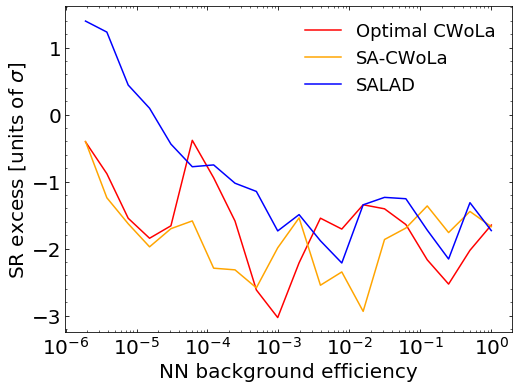

In [636]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(cutval_NO,sigval_fit_NO,label="Optimal CWoLa",color='red')
plt.plot(cutval_NO,sigval_fit_sacwola_NO,label="SA-CWoLa",color='orange')
plt.plot(cutval_NO,sigval_fit_salad_NO,label="SALAD",color='blue')
#plt.plot(cutval,sigval)
plt.xscale("log")
plt.legend(frameon=False,fontsize=18)

plt.xlabel("NN background efficiency",fontsize=20)
plt.ylabel("SR excess [units of $\sigma$]",fontsize=20)
plt.savefig('SA-CWoLa/fitnosig_optimal.pdf',bbox_inches='tight')

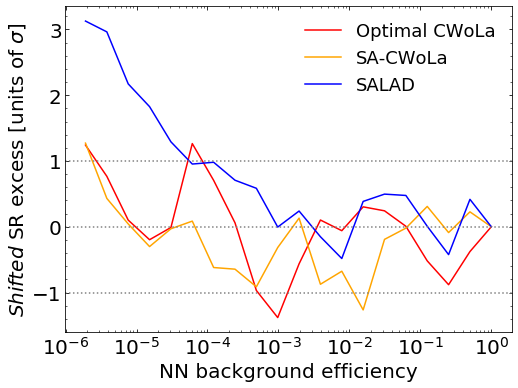

In [643]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(cutval_NO,sigval_fit_NO-sigval_fit_NO[0],label="Optimal CWoLa",color='red')
plt.plot(cutval_NO,sigval_fit_sacwola_NO-sigval_fit_sacwola_NO[0],label="SA-CWoLa",color='orange')
plt.plot(cutval_NO,sigval_fit_salad_NO-sigval_fit_salad_NO[-0],label="SALAD",color='blue')
#plt.plot(cutval,sigval)
plt.xscale("log")
plt.axhline(y=0,color="gray",ls=":")
plt.axhline(y=1,color="gray",ls=":")
plt.axhline(y=-1,color="gray",ls=":")
plt.legend(frameon=False,fontsize=18)

plt.xlabel("NN background efficiency",fontsize=20)
plt.ylabel("$Shifted$ SR excess [units of $\sigma$]",fontsize=20)
plt.savefig('SA-CWoLa/fitnosig_optimal_shifted.pdf',bbox_inches='tight')

## Old

In [3]:
def computemjj_np(event):
    px1 = event[:,0]
    py1 = event[:,1]
    pz1 = event[:,2]
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[:,3]**2)
    
    px2 = event[:,7]
    py2 = event[:,8]
    pz2 = event[:,9]
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+event[:,10]**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.sqrt(m2)

In [4]:
signal_np = signal.to_numpy()
pythia_np = pythia.to_numpy()
herwig_np = herwig.to_numpy()

In [5]:
mjj_signal = computemjj_np(signal_np)
mjj_pythia = computemjj_np(pythia_np)
mjj_herwig = computemjj_np(herwig_np)

First thing to do is to make some plots of the basic features.

In [6]:
minmass_pythia = np.array(pythia[['mj1','mj2']].min(axis=1))
maxmass_pythia = np.array(pythia[['mj1','mj2']].max(axis=1))
minmass_herwig = np.array(herwig[['mj1','mj2']].min(axis=1))
maxmass_herwig = np.array(herwig[['mj1','mj2']].max(axis=1))
minmass_signal = np.array(signal[['mj1','mj2']].min(axis=1))
maxmass_signal = np.array(signal[['mj1','mj2']].max(axis=1))

In [7]:
tau21A_pythia = pythia_np[:,5]/(0.00001+pythia_np[:,4])
tau21B_pythia = pythia_np[:,12]/(0.00001+pythia_np[:,11])
m1_pythia = pythia_np[:,3]
m2_pythia = pythia_np[:,10]
mymasses_pythia = np.concatenate((np.reshape(m1_pythia,[len(m1_pythia),1]),np.reshape(m2_pythia,[len(m2_pythia),1])),axis=1)
mytaus_pythia = np.concatenate((np.reshape(tau21A_pythia,[len(tau21A_pythia),1]),np.reshape(tau21B_pythia,[len(tau21B_pythia),1])),axis=1)
order_pythia = [np.argmax(mymasses_pythia[i]) for i in range(len(mymasses_pythia))]
tau21a_pythia = [mytaus_pythia[i][order_pythia[i]] for i in range(len(order_pythia))]
tau21b_pythia = [mytaus_pythia[i][1-order_pythia[i]] for i in range(len(order_pythia))]

tau21A_herwig = herwig_np[:,5]/(0.00001+herwig_np[:,4])
tau21B_herwig = herwig_np[:,12]/(0.00001+herwig_np[:,11])
m1_herwig = herwig_np[:,3]
m2_herwig = herwig_np[:,10]
mymasses_herwig = np.concatenate((np.reshape(m1_herwig,[len(m1_herwig),1]),np.reshape(m2_herwig,[len(m2_herwig),1])),axis=1)
mytaus_herwig = np.concatenate((np.reshape(tau21A_herwig,[len(tau21A_herwig),1]),np.reshape(tau21B_herwig,[len(tau21B_herwig),1])),axis=1)
order_herwig = [np.argmax(mymasses_herwig[i]) for i in range(len(mymasses_herwig))]
tau21a_herwig = [mytaus_herwig[i][order_herwig[i]] for i in range(len(order_herwig))]
tau21b_herwig = [mytaus_herwig[i][1-order_herwig[i]] for i in range(len(order_herwig))]

tau21A_signal = signal_np[:,5]/(0.00001+signal_np[:,4])
tau21B_signal = signal_np[:,12]/(0.00001+signal_np[:,11])
m1_signal = signal_np[:,3]
m2_signal = signal_np[:,10]
mymasses_signal = np.concatenate((np.reshape(m1_signal,[len(m1_signal),1]),np.reshape(m2_signal,[len(m2_signal),1])),axis=1)
mytaus_signal = np.concatenate((np.reshape(tau21A_signal,[len(tau21A_signal),1]),np.reshape(tau21B_signal,[len(tau21B_signal),1])),axis=1)
order_signal = [np.argmax(mymasses_signal[i]) for i in range(len(mymasses_signal))]
tau21a_signal = [mytaus_signal[i][order_signal[i]] for i in range(len(order_signal))]
tau21b_signal = [mytaus_signal[i][1-order_signal[i]] for i in range(len(order_signal))]

Now, let's prepare the ML input

In [8]:
def rs(x):
    return np.reshape(x,[len(x),1])

In [9]:
x_signal = np.concatenate((rs(maxmass_signal)/1000.,rs(minmass_signal)/1000.,rs(tau21a_signal),rs(tau21b_signal)),axis=1)
x_data = np.concatenate((rs(maxmass_pythia + 0.1*mjj_pythia)/1000.,rs(minmass_pythia + 0.1*mjj_pythia)/1000.,rs(tau21a_pythia),rs(tau21b_pythia)),axis=1)
x_MC = np.concatenate((rs(maxmass_herwig + 0.1*mjj_herwig)/1000.,rs(minmass_herwig + 0.1*mjj_herwig)/1000.,rs(tau21a_herwig),rs(tau21b_herwig)),axis=1)

In [10]:
SR_low = 3250
SR_high = 3750

SB_low = 3250-250
SB_high = 3750+250

In [11]:
x_SR_signal = x_signal[(mjj_signal > SR_low)*(mjj_signal < SR_high)]
x_SR_data = x_data[(mjj_pythia > SR_low)*(mjj_pythia < SR_high)]
x_SR_MC = x_MC[(mjj_herwig > SR_low)*(mjj_herwig < SR_high)]

x_SB_signal = x_signal[(mjj_signal < SR_low)*(mjj_signal > SB_low)+(mjj_signal < SB_high)*(mjj_signal > SR_high)]
x_SB_data = x_data[(mjj_pythia < SR_low)*(mjj_pythia > SB_low)+(mjj_pythia < SB_high)*(mjj_pythia > SR_high)]
x_SB_MC = x_MC[(mjj_herwig < SR_low)*(mjj_herwig > SB_low)+(mjj_herwig < SB_high)*(mjj_herwig > SR_high)]

In [12]:
print(len(x_SR_data))
print(len(x_SB_data))

152668
170647


0.0
Train on 323877 samples, validate on 323878 samples
Epoch 1/20
323877/323877 [==============================] - 14s 43us/step - loss: 0.6786 - acc: 0.5415 - val_loss: 0.6714 - val_acc: 0.5542
Epoch 2/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.6634 - acc: 0.5570 - val_loss: 0.6616 - val_acc: 0.5500
Epoch 3/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.6624 - acc: 0.5592 - val_loss: 0.6608 - val_acc: 0.5575
Epoch 4/20
323877/323877 [==============================] - 11s 34us/step - loss: 0.6620 - acc: 0.5607 - val_loss: 0.6672 - val_acc: 0.5578
Epoch 5/20
323877/323877 [==============================] - 11s 34us/step - loss: 0.6607 - acc: 0.5620 - val_loss: 0.6639 - val_acc: 0.5605
Epoch 6/20
323877/323877 [==============================] - 11s 34us/step - loss: 0.6605 - acc: 0.5621 - val_loss: 0.6617 - val_acc: 0.5605
Epoch 7/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.6607 - acc: 0.5640 -

Epoch 18/20
323877/323877 [==============================] - 11s 34us/step - loss: 0.2638 - acc: 0.5620 - val_loss: 0.2628 - val_acc: 0.5681
Epoch 19/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.2634 - acc: 0.5643 - val_loss: 0.2633 - val_acc: 0.5660
Epoch 20/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.2635 - acc: 0.5612 - val_loss: 0.2633 - val_acc: 0.5619
0.2 0.6014771088836305
0.3
Train on 323877 samples, validate on 323878 samples
Epoch 1/20
323877/323877 [==============================] - 12s 37us/step - loss: 0.2402 - acc: 0.5313 - val_loss: 0.2344 - val_acc: 0.5374
Epoch 2/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.2348 - acc: 0.5461 - val_loss: 0.2341 - val_acc: 0.5504
Epoch 3/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.2324 - acc: 0.5560 - val_loss: 0.2309 - val_acc: 0.5547
Epoch 4/20
323877/323877 [==============================] - 11s 35us/step - lo

323877/323877 [==============================] - 12s 37us/step - loss: -0.0392 - acc: 0.5372 - val_loss: -0.0241 - val_acc: 0.5278
Epoch 11/20
323877/323877 [==============================] - 12s 36us/step - loss: -0.0388 - acc: 0.5385 - val_loss: -0.0489 - val_acc: 0.5289
Epoch 12/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.0410 - acc: 0.5376 - val_loss: -0.0447 - val_acc: 0.5301
Epoch 13/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.0408 - acc: 0.5379 - val_loss: -0.0294 - val_acc: 0.5273
Epoch 14/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.0440 - acc: 0.5393 - val_loss: -0.0466 - val_acc: 0.5339
Epoch 15/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.0455 - acc: 0.5359 - val_loss: -0.0501 - val_acc: 0.5306
Epoch 16/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.0472 - acc: 0.5384 - val_loss: 0.0108 - val_acc: 0.5322
Epoch 17/20


Epoch 6/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epoch 7/20
323877/323877 [==============================] - 12s 38us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epoch 8/20
323877/323877 [==============================] - 12s 38us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epoch 9/20
323877/323877 [==============================] - 12s 38us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epoch 10/20
323877/323877 [==============================] - 12s 38us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epoch 11/20
323877/323877 [==============================] - 12s 38us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epoch 12/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epo

323877/323877 [==============================] - 12s 38us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 3/20
323877/323877 [==============================] - 13s 39us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 4/20
323877/323877 [==============================] - 13s 39us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 5/20
323877/323877 [==============================] - 12s 39us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 6/20
323877/323877 [==============================] - 13s 39us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 7/20
323877/323877 [==============================] - 12s 39us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 8/20
323877/323877 [==============================] - 12s 38us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 9/20
323877

323877/323877 [==============================] - 13s 40us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
Epoch 15/20
323877/323877 [==============================] - 13s 40us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
Epoch 16/20
323877/323877 [==============================] - 13s 40us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
Epoch 17/20
323877/323877 [==============================] - 13s 39us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
Epoch 18/20
323877/323877 [==============================] - 13s 39us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
Epoch 19/20
323877/323877 [==============================] - 13s 40us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
Epoch 20/20
323877/323877 [==============================] - 13s 40us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
1.9 0.5
2.0

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


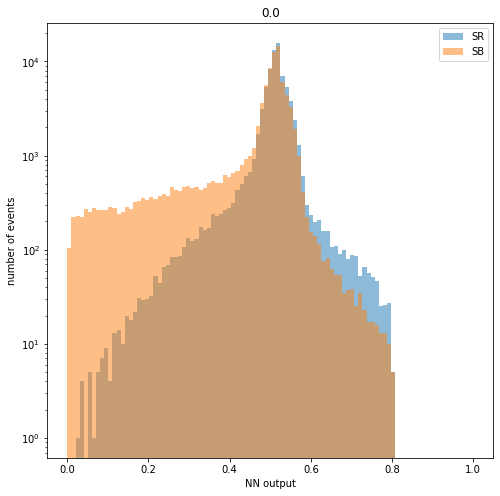

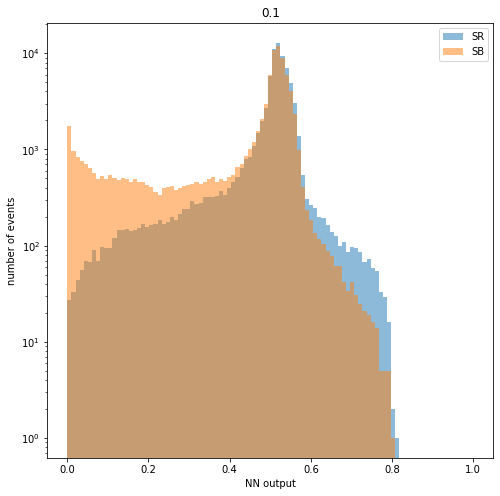

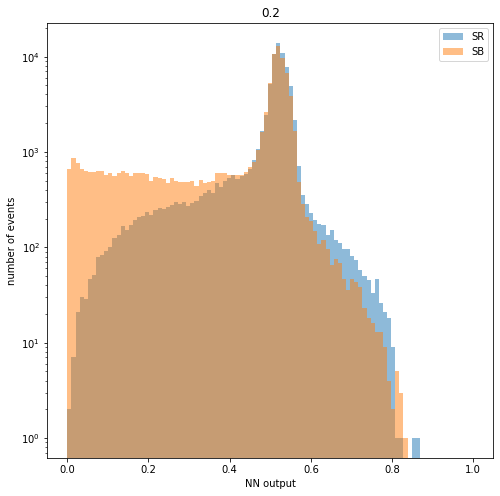

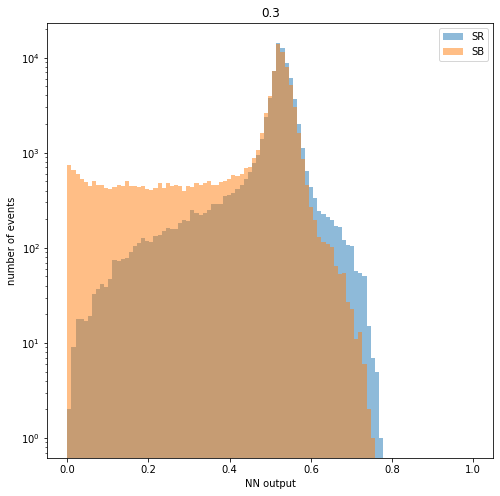

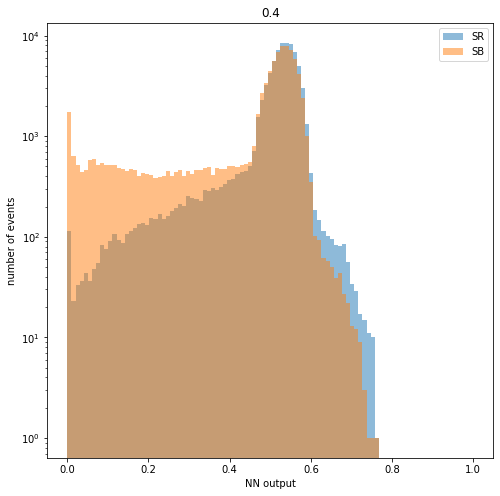

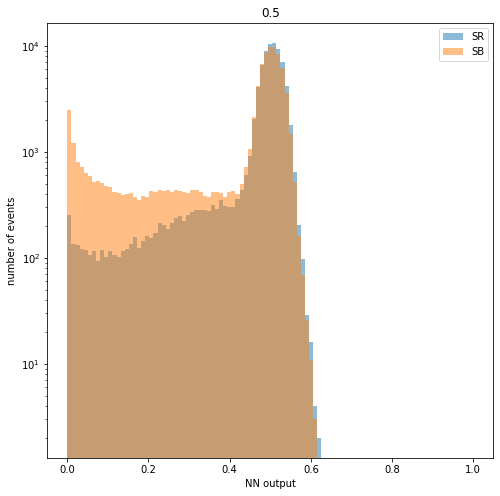

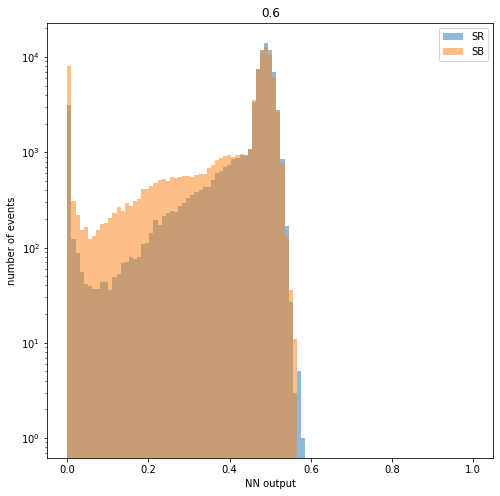

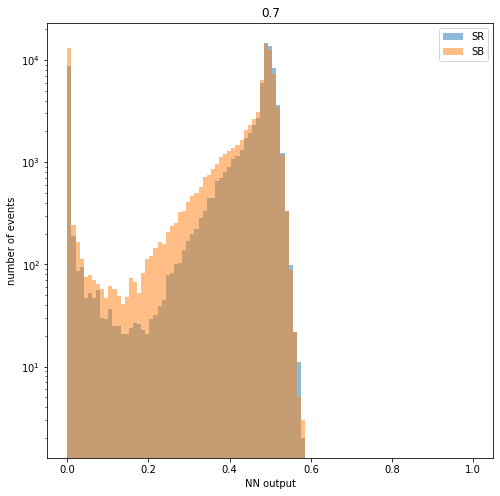

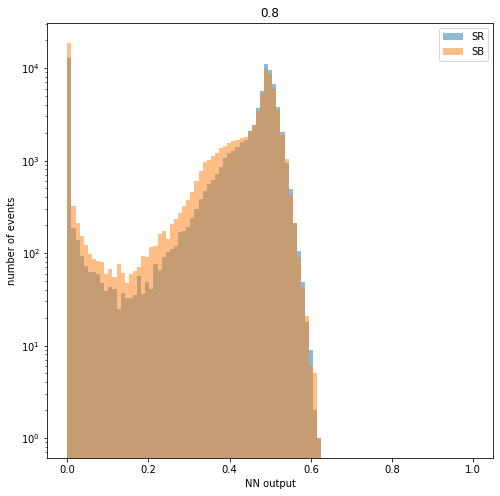

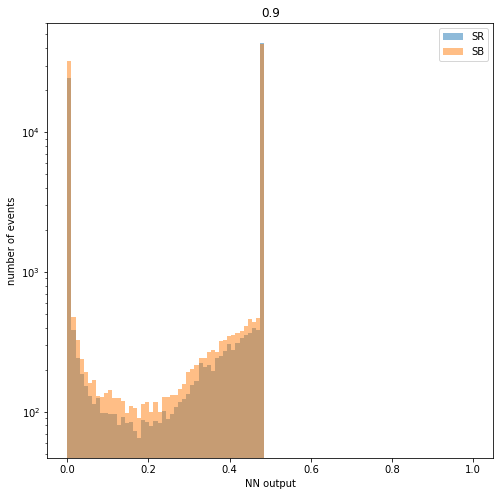

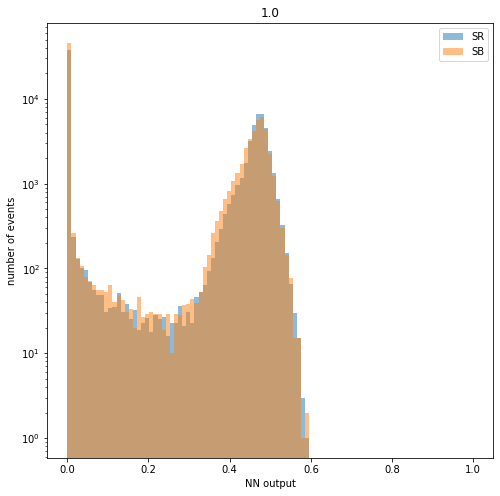

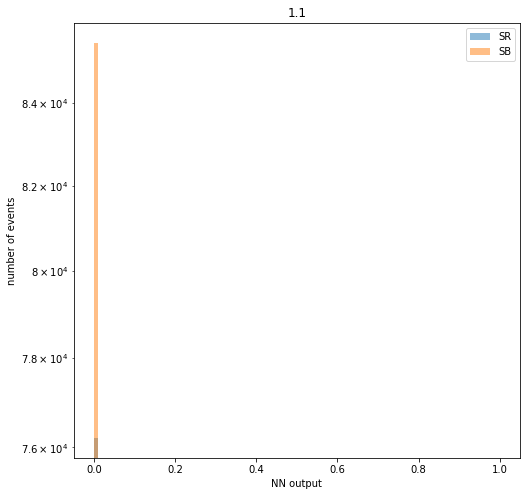

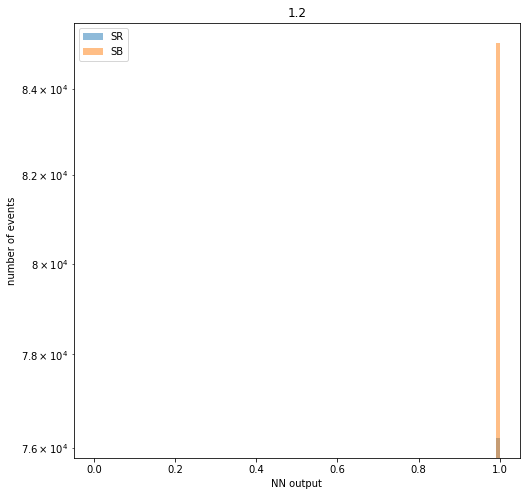

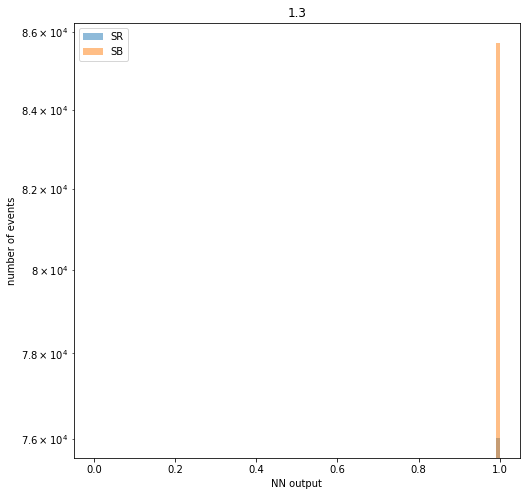

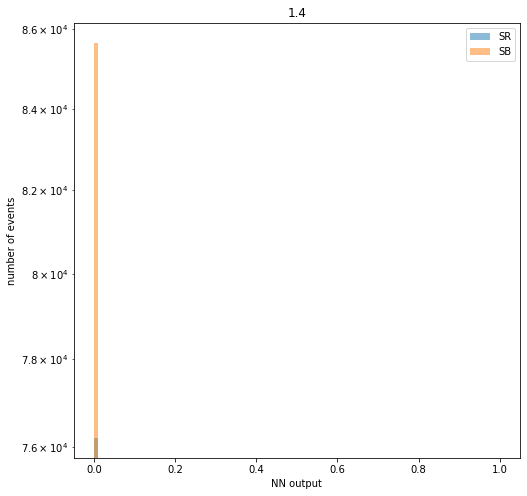

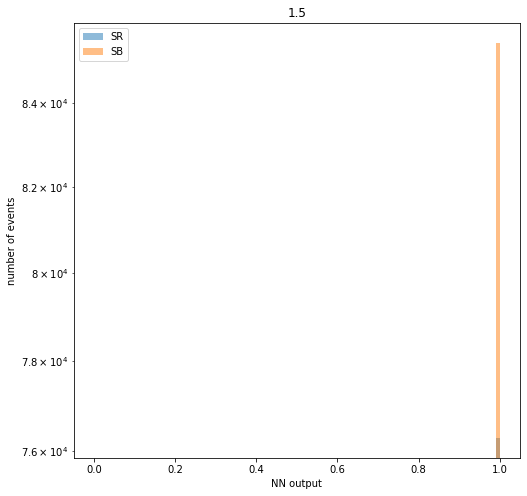

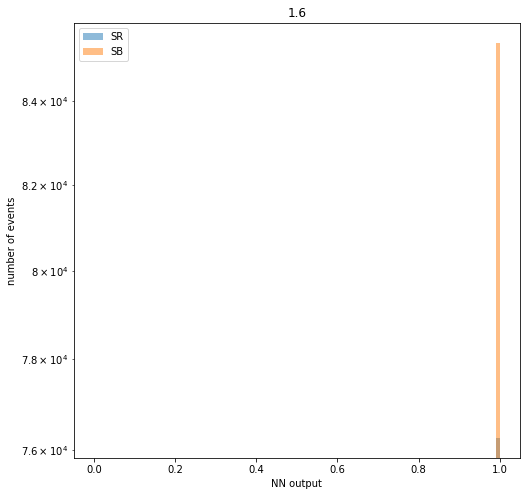

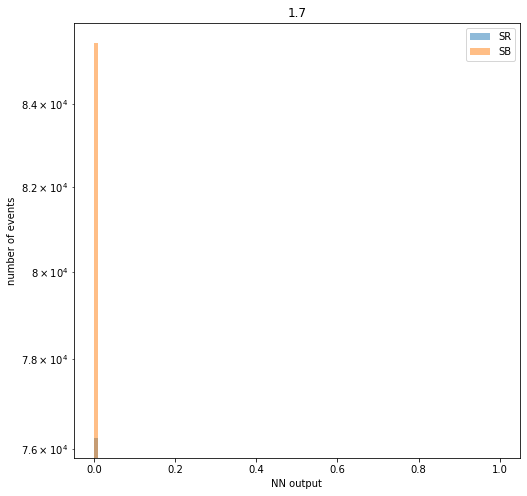

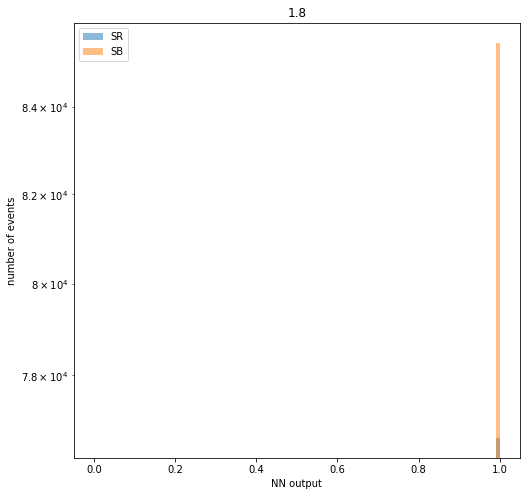

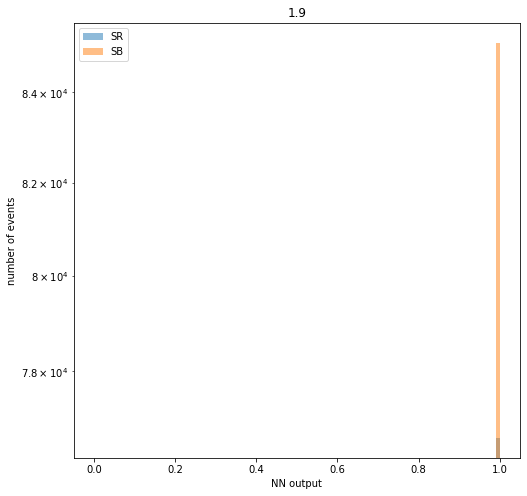

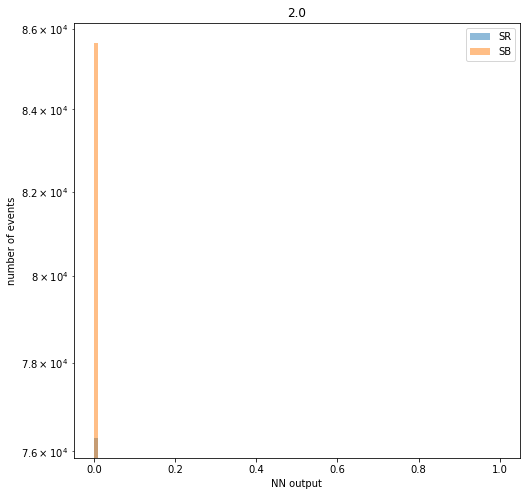

In [13]:
myaucs = []
histories = []
nepochs = 20
for mylambda in [0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.]:
    
    print(mylambda)

    X = np.concatenate([x_SR_data,x_SB_data,x_SR_MC,x_SB_MC])
    Y = np.concatenate([np.ones(len(x_SR_data)),np.zeros(len(x_SB_data)),np.ones(len(x_SR_MC)),np.zeros(len(x_SB_MC))])
    W = np.concatenate([np.ones(len(x_SR_data)),np.ones(len(x_SB_data)),-mylambda*np.ones(len(x_SR_MC)),-mylambda*np.ones(len(x_SB_MC))])
    X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(X, Y, W, test_size=0.5)

    model = Sequential()
    model.add(Dense(64, input_dim=4, activation='relu')) 
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train,Y_train, epochs=nepochs, sample_weight = W_train, batch_size=200,validation_data=(X_test,Y_test,W_test))
    histories+=[history]
    
    preds_SR = model.predict(X_test[(Y_test==1)*(W_test>0)],batch_size=200)
    preds_SB = model.predict(X_test[(Y_test==0)*(W_test>0)],batch_size=200)
    
    print(mylambda,roc_auc_score(np.concatenate([np.ones(len(preds_SR)),np.zeros(len(preds_SB))]), np.concatenate([preds_SR,preds_SB])))
    myaucs+=[roc_auc_score(np.concatenate([np.ones(len(preds_SR)),np.zeros(len(preds_SB))]), np.concatenate([preds_SR,preds_SB]))]
    
    fig = plt.figure(figsize=(8, 8))
    _,_,_=plt.hist(preds_SR,label="SR",bins=np.linspace(0,1,100),alpha=0.5)
    _,_,_=plt.hist(preds_SB,label="SB",bins=np.linspace(0,1,100),alpha=0.5)
    plt.yscale("log")
    plt.xlabel("NN output")
    plt.ylabel("number of events")
    plt.title(str(mylambda))
    plt.legend()


Text(0.5, 0, '$\\lambda$')

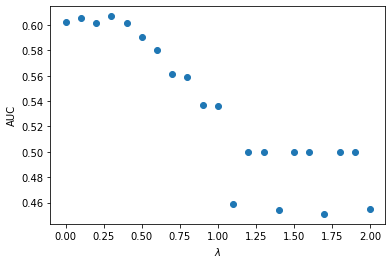

In [14]:
plt.plot([0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.],myaucs,marker="o",linestyle="none")
plt.ylabel("AUC")
plt.xlabel(r"$\lambda$")

In [15]:
x_SR_signal = x_signal[(mjj_signal > SR_low)*(mjj_signal < SR_high)]
x_SR_data = x_data[(mjj_pythia > SR_low)*(mjj_pythia < SR_high)]
x_SR_MC = x_MC[(mjj_herwig > SR_low)*(mjj_herwig < SR_high)]

x_SB_signal = x_signal[(mjj_signal < SR_low)*(mjj_signal > SB_low)+(mjj_signal < SB_high)*(mjj_signal > SR_high)]
x_SB_data = x_data[(mjj_pythia < SR_low)*(mjj_pythia > SB_low)+(mjj_pythia < SB_high)*(mjj_pythia > SR_high)]
x_SB_MC = x_MC[(mjj_herwig < SR_low)*(mjj_herwig > SB_low)+(mjj_herwig < SB_high)*(mjj_herwig > SR_high)]

x_SB_low_data = x_data[(mjj_pythia < SR_low)*(mjj_pythia > SB_low)]
x_SB_high_data = x_data[(mjj_pythia < SB_high)*(mjj_pythia > SR_high)]

In [16]:
print(len(x_SB_low_data))
print(len(x_SB_high_data))
print(len(x_SR_data))

127601
43046
152668


1.0 0.8946421560296988 1.1964483036966795 3.5466245411884962
Train on 246981 samples, validate on 246981 samples
Epoch 1/20
246981/246981 [==============================] - 11s 44us/step - loss: 0.6439 - acc: 0.5005 - val_loss: 0.6334 - val_acc: 0.4951
Epoch 2/20
246981/246981 [==============================] - 10s 40us/step - loss: 0.6281 - acc: 0.5305 - val_loss: 0.6241 - val_acc: 0.5274
Epoch 3/20
246981/246981 [==============================] - 10s 41us/step - loss: 0.6267 - acc: 0.5335 - val_loss: 0.6245 - val_acc: 0.5250
Epoch 4/20
246981/246981 [==============================] - 10s 40us/step - loss: 0.6252 - acc: 0.5338 - val_loss: 0.6274 - val_acc: 0.5479
Epoch 5/20
246981/246981 [==============================] - 10s 41us/step - loss: 0.6251 - acc: 0.5335 - val_loss: 0.6297 - val_acc: 0.5124
Epoch 6/20
246981/246981 [==============================] - 10s 40us/step - loss: 0.6249 - acc: 0.5329 - val_loss: 0.6236 - val_acc: 0.5233
Epoch 7/20
246981/246981 [=====================

246981/246981 [==============================] - 10s 39us/step - loss: -0.3089 - acc: 0.4932 - val_loss: -0.3496 - val_acc: 0.4787
Epoch 12/20
246981/246981 [==============================] - 10s 41us/step - loss: -0.2945 - acc: 0.4942 - val_loss: -0.3576 - val_acc: 0.4997
Epoch 13/20
246981/246981 [==============================] - 10s 42us/step - loss: -0.3004 - acc: 0.4938 - val_loss: -0.3290 - val_acc: 0.5023
Epoch 14/20
246981/246981 [==============================] - 10s 42us/step - loss: -0.2939 - acc: 0.4958 - val_loss: -0.3456 - val_acc: 0.5036
Epoch 15/20
246981/246981 [==============================] - 10s 42us/step - loss: -0.3038 - acc: 0.4941 - val_loss: -0.3337 - val_acc: 0.5219
Epoch 16/20
246981/246981 [==============================] - 10s 40us/step - loss: -0.3036 - acc: 0.4944 - val_loss: -0.2234 - val_acc: 0.5414
Epoch 17/20
246981/246981 [==============================] - 10s 42us/step - loss: -0.3006 - acc: 0.4946 - val_loss: -0.2650 - val_acc: 0.4677
Epoch 18/20

246981/246981 [==============================] - 11s 43us/step - loss: -3.0234 - acc: 0.4890 - val_loss: -3.0269 - val_acc: 0.4950
1.0 0.578367982774179
1.0 0.8946421560296988 1.1964483036966795 3.5466245411884962
Train on 246981 samples, validate on 246981 samples
Epoch 1/20
246981/246981 [==============================] - 13s 51us/step - loss: -2.2884 - acc: 0.4946 - val_loss: -3.6154 - val_acc: 0.4977
Epoch 2/20
246981/246981 [==============================] - 11s 43us/step - loss: -3.5850 - acc: 0.4884 - val_loss: -3.5961 - val_acc: 0.5103
Epoch 3/20
246981/246981 [==============================] - 11s 43us/step - loss: -3.6251 - acc: 0.4890 - val_loss: -3.7146 - val_acc: 0.4899
Epoch 4/20
246981/246981 [==============================] - 10s 42us/step - loss: -3.6326 - acc: 0.4887 - val_loss: -3.6812 - val_acc: 0.4811
Epoch 5/20
246981/246981 [==============================] - 11s 44us/step - loss: -3.6521 - acc: 0.4899 - val_loss: -3.7213 - val_acc: 0.4912
Epoch 6/20
246981/246981

Epoch 15/20
246981/246981 [==============================] - 11s 43us/step - loss: -5.0143 - acc: 0.4884 - val_loss: -5.1695 - val_acc: 0.4958
Epoch 16/20
246981/246981 [==============================] - 11s 43us/step - loss: -5.0243 - acc: 0.4872 - val_loss: -5.0165 - val_acc: 0.5101
Epoch 17/20
246981/246981 [==============================] - 11s 44us/step - loss: -5.0073 - acc: 0.4819 - val_loss: -5.1764 - val_acc: 0.4763
Epoch 18/20
246981/246981 [==============================] - 11s 44us/step - loss: -5.0404 - acc: 0.4880 - val_loss: -4.9867 - val_acc: 0.4614
Epoch 19/20
246981/246981 [==============================] - 11s 43us/step - loss: -4.9986 - acc: 0.4844 - val_loss: -5.2166 - val_acc: 0.4782
Epoch 20/20
246981/246981 [==============================] - 11s 43us/step - loss: -5.0143 - acc: 0.4845 - val_loss: -5.1191 - val_acc: 0.5024
1.3 0.5806506278873107
1.0 0.8946421560296988 1.1964483036966795 3.5466245411884962
Train on 246981 samples, validate on 246981 samples
Epoch 

246981/246981 [==============================] - 11s 43us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 4/20
246981/246981 [==============================] - 11s 44us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 5/20
246981/246981 [==============================] - 11s 44us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 6/20
246981/246981 [==============================] - 11s 44us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 7/20
246981/246981 [==============================] - 11s 44us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 8/20
246981/246981 [==============================] - 11s 45us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 9/20
246981/246981 [==============================] - 11s 44us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 10/20
24698

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


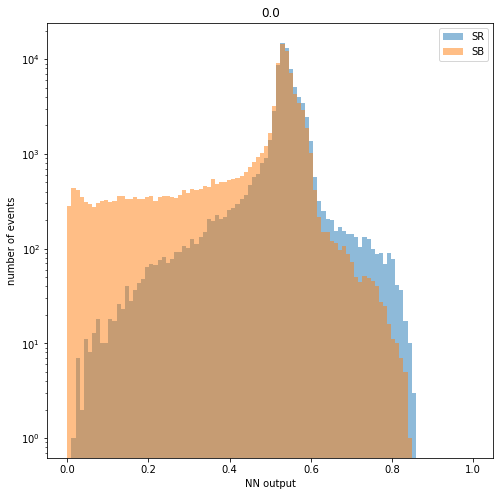

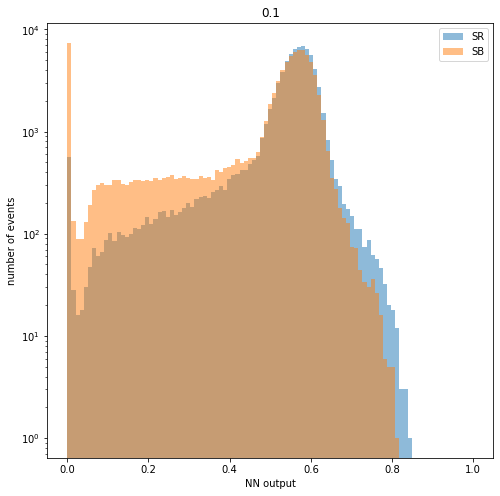

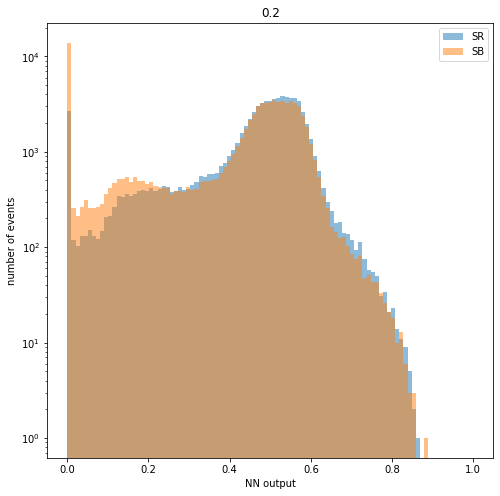

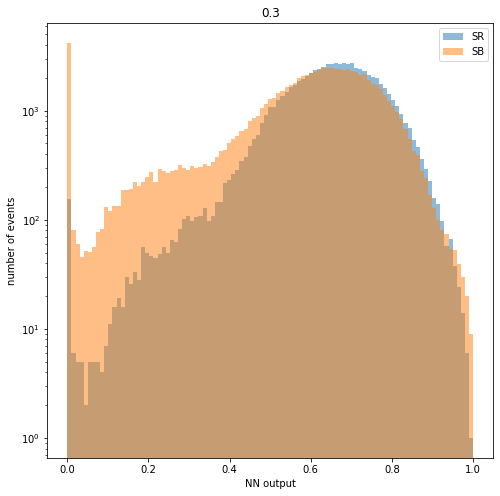

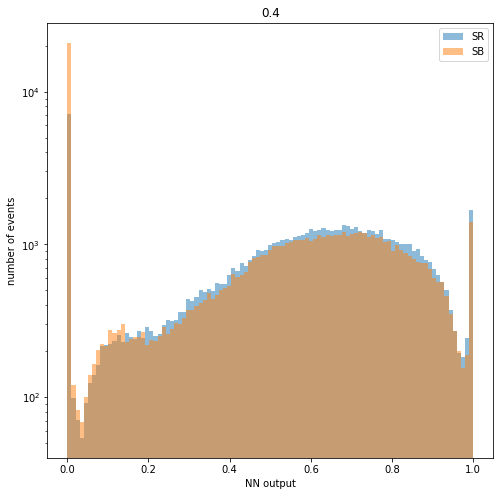

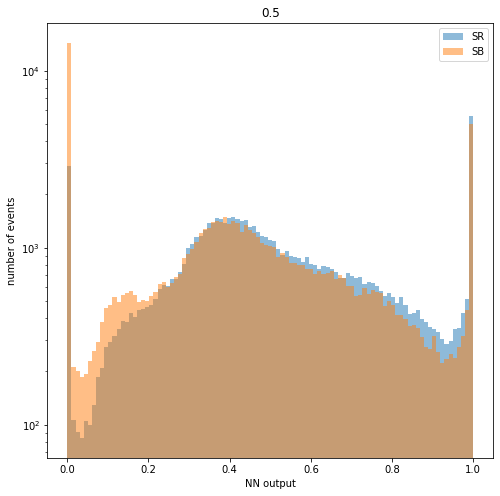

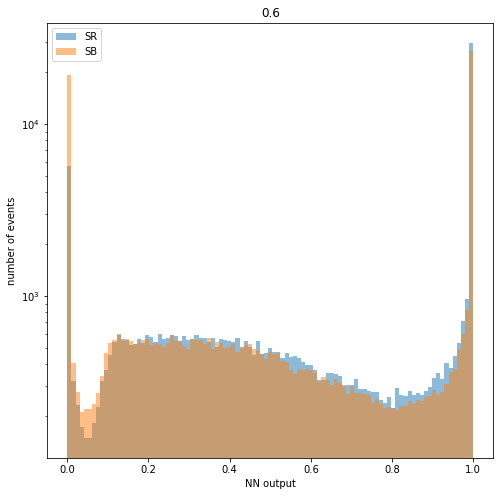

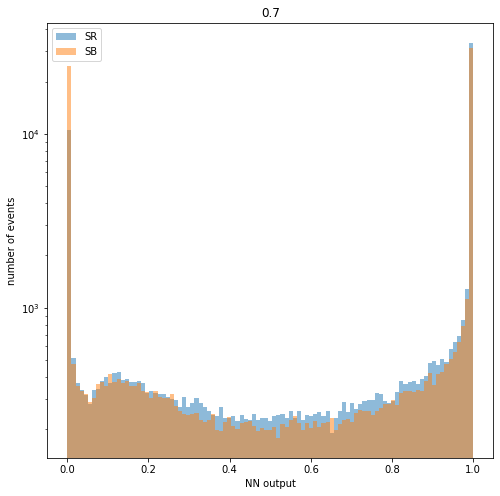

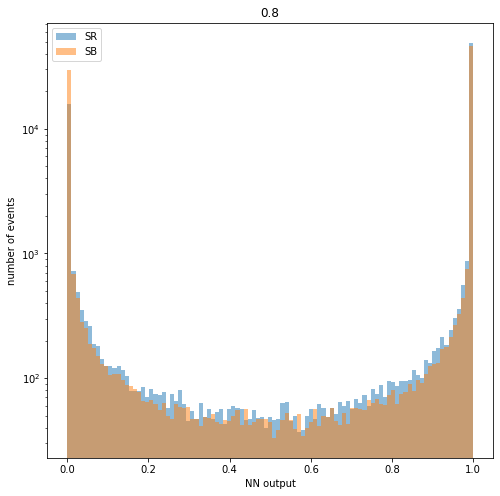

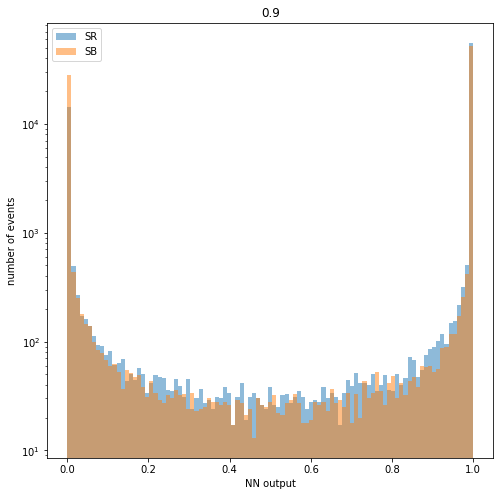

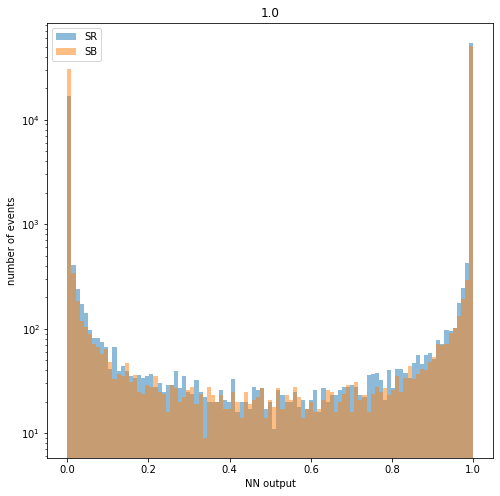

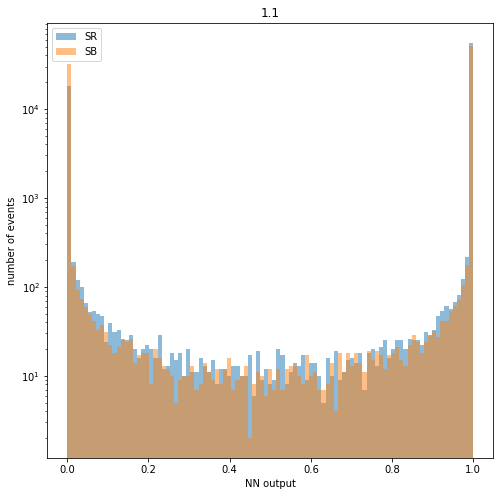

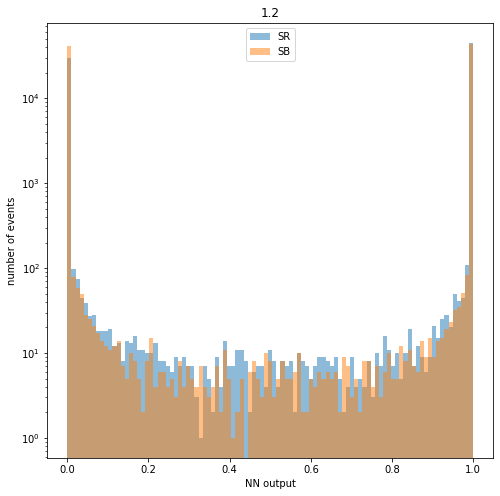

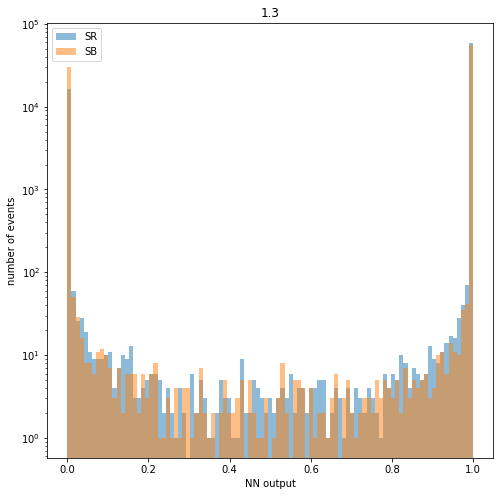

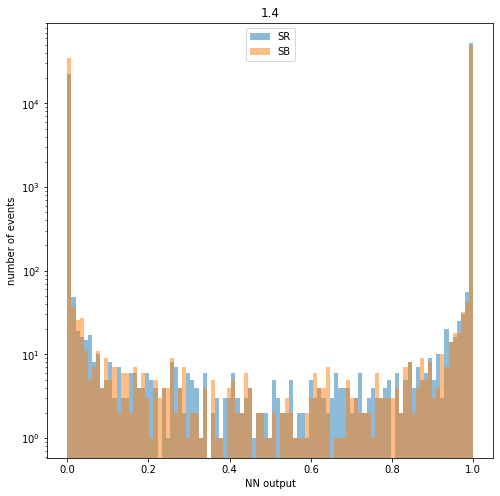

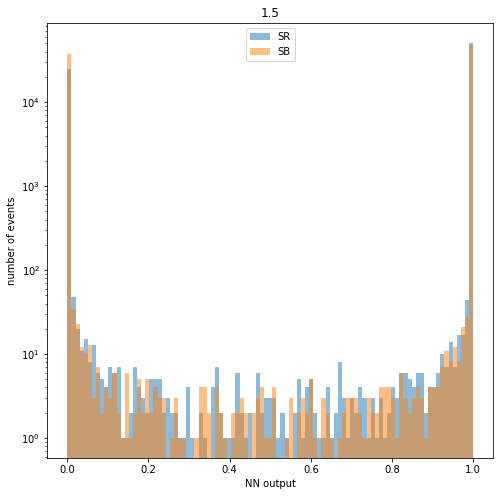

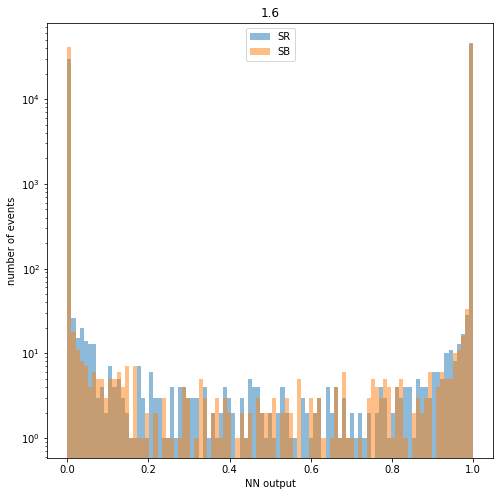

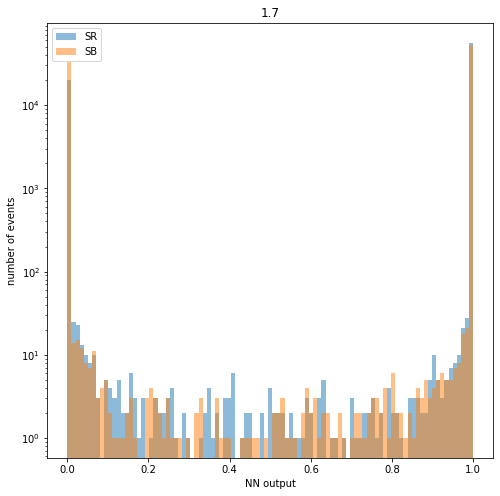

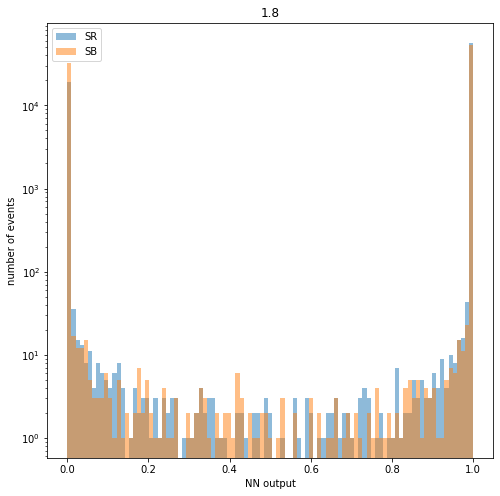

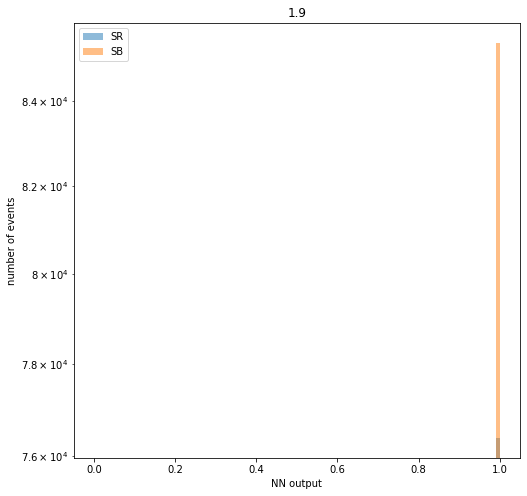

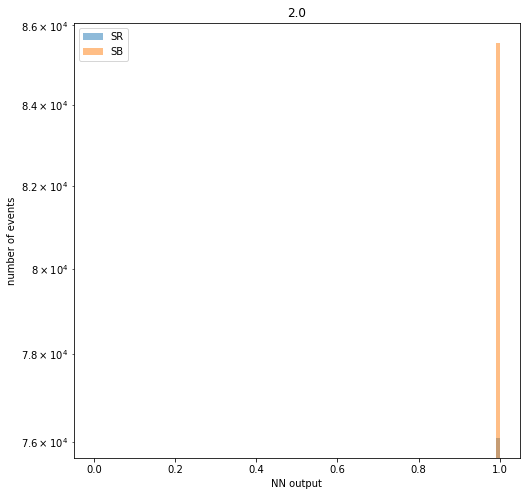

In [17]:
myaucs2 = []
histories2 = []
nepochs = 20
for mylambda in [0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.]:
    X = np.concatenate([x_SR_data,x_SB_data,x_SB_low_data,x_SB_high_data])
    Y = np.concatenate([np.ones(len(x_SR_data)),np.zeros(len(x_SB_data)),np.ones(len(x_SB_low_data)),np.zeros(len(x_SB_high_data))])
    w_SR = 1.
    w_SB = len(x_SR_data)/len(x_SB_data)
    w_SB_low = len(x_SR_data)/len(x_SB_low_data)
    w_SB_high = len(x_SR_data)/len(x_SB_high_data)
    print(w_SR,w_SB,w_SB_low,w_SB_high)
    W = np.concatenate([w_SR*np.ones(len(x_SR_data)),w_SB*np.ones(len(x_SB_data)),-mylambda*w_SB_low*np.ones(len(x_SB_low_data)),-mylambda*w_SB_high*np.ones(len(x_SB_high_data))])
    X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(X, Y, W, test_size=0.5)

    model = Sequential()
    model.add(Dense(64, input_dim=4, activation='relu')) 
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train,Y_train, epochs=nepochs, sample_weight = W_train, batch_size=200,validation_data=(X_test,Y_test,W_test))

    histories2+=[history]
    
    preds_SR = model.predict(X_test[(Y_test==1)*(W_test>0)],batch_size=200)
    preds_SB = model.predict(X_test[(Y_test==0)*(W_test>0)],batch_size=200)

    print(mylambda,roc_auc_score(np.concatenate([np.ones(len(preds_SR)),np.zeros(len(preds_SB))]), np.concatenate([preds_SR,preds_SB])))
    myaucs2+=[roc_auc_score(np.concatenate([np.ones(len(preds_SR)),np.zeros(len(preds_SB))]), np.concatenate([preds_SR,preds_SB]))]
    
    fig = plt.figure(figsize=(8, 8))
    _,_,_=plt.hist(preds_SR,label="SR",bins=np.linspace(0,1,100),alpha=0.5)
    _,_,_=plt.hist(preds_SB,label="SB",bins=np.linspace(0,1,100),alpha=0.5)
    plt.yscale("log")
    plt.xlabel("NN output")
    plt.ylabel("number of events")
    plt.title(str(mylambda))
    plt.legend()

Text(0.5, 0, '$\\lambda$')

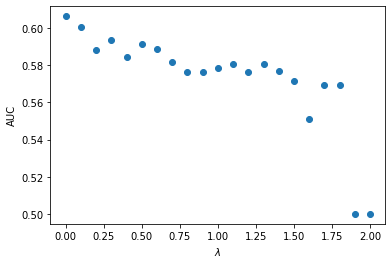

In [20]:
plt.plot([0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.],myaucs2,marker="o",linestyle="none")
plt.ylabel("AUC")
plt.xlabel(r"$\lambda$")
#plt.xlim([0,1])

In [ ]:
#Now, try with signal injected to make sure that is preserved.

In [26]:
mylambda = 0.
X = np.concatenate([x_SR_data,x_SB_data,x_SR_MC,x_SB_MC,x_SR_signal,x_SB_signal])
Y = np.concatenate([np.ones(len(x_SR_data)),np.zeros(len(x_SB_data)),np.ones(len(x_SR_MC)),np.zeros(len(x_SB_MC)),np.ones(len(x_SR_signal)),np.zeros(len(x_SB_signal))])
W = np.concatenate([np.ones(len(x_SR_data)),np.ones(len(x_SB_data)),-mylambda*np.ones(len(x_SR_MC)),-mylambda*np.ones(len(x_SB_MC)),np.ones(len(x_SR_signal)),np.ones(len(x_SB_signal))])
X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(X, Y, W, test_size=0.5)

model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu')) 
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train,Y_train, epochs=nepochs, sample_weight = W_train, batch_size=200,validation_data=(X_test,Y_test,W_test))

preds_SR = model.predict(np.concatenate([x_SR_data,x_SB_signal]),batch_size=200)

Train on 370845 samples, validate on 370845 samples
Epoch 1/20
370845/370845 [==============================] - 19s 52us/step - loss: 0.6179 - acc: 0.5684 - val_loss: 0.6066 - val_acc: 0.5791
Epoch 2/20
370845/370845 [==============================] - 17s 45us/step - loss: 0.6000 - acc: 0.5931 - val_loss: 0.5956 - val_acc: 0.5966
Epoch 3/20
370845/370845 [==============================] - 16s 44us/step - loss: 0.5960 - acc: 0.5974 - val_loss: 0.5931 - val_acc: 0.5927
Epoch 4/20
370845/370845 [==============================] - 16s 44us/step - loss: 0.5951 - acc: 0.5991 - val_loss: 0.5917 - val_acc: 0.6048
Epoch 5/20
370845/370845 [==============================] - 16s 44us/step - loss: 0.5945 - acc: 0.5987 - val_loss: 0.5950 - val_acc: 0.6011
Epoch 6/20
370845/370845 [==============================] - 16s 44us/step - loss: 0.5943 - acc: 0.5996 - val_loss: 0.5912 - val_acc: 0.6014
Epoch 7/20
370845/370845 [==============================] - 16s 44us/step - loss: 0.5935 - acc: 0.6002 - val

ValueError: continuous format is not supported

In [35]:
fpr, tpr, thresholds_norotate = roc_curve(np.concatenate([np.zeros(len(x_SR_data)),np.ones(len(x_SB_signal))]),preds_SR[:,0])

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


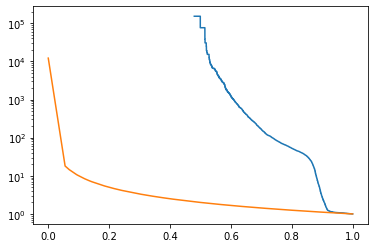

In [40]:
plt.plot(tpr,1./fpr)
plt.plot(tpr,1./tpr)
plt.yscale("log")